# Programación de la Gestión de Carga de Vehículos Eléctricos en Estacionamientos: Modelado, Heurísticas y Análisis

Las estaciones de carga para vehículos eléctricos (EVCS, por sus siglas en inglés) son infraestructuras críticas para la adopción masiva de vehículos eléctricos. Sin embargo, la operación eficiente de estas estaciones presenta un desafío complejo debido a la variabilidad en la demanda de energía, los límites de capacidad de la red eléctrica, la disponibilidad limitada de cargadores y los costos operativos asociados.

El problema abordado consiste en la optimización de la gestión de carga de múltiples vehículos eléctricos (VE) en una estación, buscando maximizar los ingresos del operador, minimizar los costos operativos y asegurar un nivel de servicio equitativo entre los usuarios, todo ello sujeto a las restricciones técnicas y operativas de la estación y de los vehículos.

En este cuaderno se exploran tres enfoques metodológicos para resolver el Problema de Programación de Estaciones de Carga de Vehículos Eléctricos (EVCS Scheduling Problem): un modelo exacto de Programación Lineal Entera Mixta (MILP), una heurística constructiva mejorada, y una metaheurística basada en Búsqueda Adaptativa de Vecindad Amplia (ALNS). Además, se detalla el proceso de calibración de hiperparámetros para los métodos aproximados y se realiza un análisis estadístico riguroso para comparar el rendimiento de los tres enfoques.

1. **Formulación Matemática (Modelo MILP)**  
   - Definición de conjuntos, parámetros y variables  
   - Función objetivo y restricciones (con expresiones en LaTeX)  
2. **Implementación del Modelo Exacto con Gurobi**  
   - Lectura de instancias  
   - Construcción y optimización del modelo  
   - Extracción de métricas  
3. **Heurística Constructiva Mejorada**  
   - Lógica y descripción paso a paso  
   - Código de implementación (función `heuristic_schedule`)  
4. **Metaheurística ALNS (Adaptive Large Neighborhood Search)**  
   - Explicación de operadores de destrucción y reparación  
   - Lógica general de ALNS  
   - Código de implementación (función `ALNS` y operadores asociados)  
5. **Optimización de Hiperparámetros con Optuna**  
   - Organización de resultados y generación de gráficas  
   - Funciones `tune_heuristic` y `tune_alns`  
6. **Ejecución de Experimentos**  
   - Scripts para ejecutar MILP, heurística y ALNS con o sin hiperparámetros 
7. **Analisis Estadistico** 
   - Comparación Heurística vs. ALNS (por instancia)
   - Comparación Global de los Tres Algoritmos
   - Análisis de Gaps

## 1. Definición del Problema e Instancias

El Problema de Programación de Estaciones de Carga de Vehículos Eléctricos (EVCS Scheduling Problem) busca determinar una asignación óptima de vehículos eléctricos (VE) a cargadores disponibles en una estación de carga durante un horizonte de planificación discreto. El objetivo es maximizar una función que considera los ingresos por la energía vendida (ponderada por la disposición a pagar de cada usuario) y los costos de operación de los cargadores, al mismo tiempo que se promueve la equidad en el nivel de servicio entre los vehículos. Esta optimización debe realizarse respetando múltiples restricciones, como la capacidad de los cargadores, el límite de potencia del transformador de la estación, el número de plazas de estacionamiento, y las ventanas temporales de los vehículos (hora de llegada y salida, energía requerida).

Las **instancias de prueba** utilizadas para este estudio se encuentran en formato JSON. Cada archivo de instancia (`test_system_i.json`) contiene información detallada sobre:
*   **Precios de energía:** Lista de precios de energía por período de tiempo.
*   **Llegadas de vehículos:** Características de cada VE, incluyendo ID, tiempos de llegada/salida, energía requerida, disposición a pagar, tasas de carga mínimas/máximas, etc.
*   **Configuración del estacionamiento:** Número de plazas, características de los cargadores (potencia, eficiencia, costo operativo), límite del transformador y resolución temporal.

Se utiliza un conjunto de 7 instancias para la evaluación y comparación de los métodos.

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import json
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import optuna

# Importaciones adicionales para visualizar y guardar gráficos de Optuna
try:
    from optuna.visualization import (
        plot_optimization_history,
        plot_param_importances,
        plot_parallel_coordinate,
        plot_contour
    )
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly o kaleido no instalado. Las gráficas de Optuna no se generarán.")


# ────────────────────────────────────────────────────────────────────────────────
# 1. LECTURA DE INSTANCIA
# ────────────────────────────────────────────────────────────────────────────────
def read_instance(filename):
    """
    Lee un archivo de instancia en formato JSON.

    Args:
        filename (str): Ruta al archivo JSON de la instancia.

    Returns:
        dict: Diccionario con los datos de la instancia.
    """
    with open(filename, 'r') as f:
        return json.load(f)

---
## 2. Modelo Exacto (MILP)

Se formula un modelo de Programación Lineal Entera Mixta (MILP) para obtener soluciones óptimas (o cercanas a la optimalidad con un gap definido) para el problema. Este modelo sirve como benchmark para evaluar el rendimiento de los métodos heurísticos.

### 2.1. Formulación Matemática

La formulación matemática del MILP se describe a continuación:

**Conjuntos e Índices:**
*   $I$: Conjunto de vehículos eléctricos.
*   $T$: Conjunto de períodos de tiempo discretos. $T_i \subseteq T$ es el subconjunto de períodos donde el vehículo $i \in I$ está presente en la estación.
*   $C$: Conjunto de cargadores. $C_i \subseteq C$ es el subconjunto de cargadores compatibles con el vehículo $i \in I$.

**Parámetros:**
*   $price_t$: Precio de la energía en el período $t \in T$.
*   $\Delta t$: Duración de un período de tiempo (resolución temporal).
*   $\alpha_i, \beta_i$: Tiempos de llegada y salida del vehículo $i \in I$.
*   $r_i$: Energía requerida por el vehículo $i \in I$ (en kWh).
*   $w_i$: Factor de disposición a pagar del vehículo $i \in I$.
*   $P_c$: Potencia del cargador $c \in C$ (en kW).
*   $\eta_c^c$: Eficiencia del cargador $c \in C$.
*   $o_c$: Costo de operación por hora del cargador $c \in C$.
*   $N_s$: Número total de plazas de estacionamiento/carga.
*   $L$: Límite de potencia del transformador de la estación (en kW).
*   $r_{min,i}, r_{max,i}$: Tasas de carga mínima y máxima aceptables/soportadas por el vehículo $i$.
*   $M$: Constante Big-M suficientemente grande.
*   $\delta$: Parámetro de penalización para el término de equidad en la función objetivo.

**Variables de Decisión:**
*   $x_{itc} \in \{0, 1\}$: Variable binaria que es 1 si el vehículo $i$ se carga en el cargador $c$ durante el período $t$, y 0 en caso contrario.
*   $z_{it} \in \{0, 1\}$: Variable binaria que es 1 si el vehículo $i$ está asignado a algún cargador (ocupando una plaza) en el período $t$, y 0 en caso contrario.
*   $E_i \ge 0$: Energía total entregada al vehículo $i$ (en kWh).
*   $F_i \ge 0$: Tiempo de finalización de la carga para el vehículo $i$.
*   $f_{var} \ge 0$: Nivel de servicio promedio (para el término de equidad).

**Función Objetivo:**
Se busca maximizar el beneficio neto, considerando ingresos, costos operativos y una penalización por inequidad en el servicio:
$$ \text{Maximizar} \sum_{i \in I} \sum_{t \in T_i} \sum_{c \in C_i} (w_i \cdot price_t \cdot P_c \cdot \Delta t \cdot \eta_c^c \cdot x_{itc}) - \sum_{i \in I} \sum_{t \in T_i} \sum_{c \in C_i} (o_c \cdot \Delta t \cdot x_{itc}) - \delta \sum_{i \in I} \left( \frac{E_i}{r_i} - f_{var} \right)^2 $$

**Restricciones:**
1.  **Unicidad de cargador por período (R1):** Cada cargador puede ser usado por a lo sumo un vehículo en cada período.
    $$ \sum_{i \in I: (i,t,c) \in x} x_{itc} \le 1 \quad \forall c \in C, \forall t \in T $$
2.  **Unicidad de vehículo por cargador y período (R2):** Cada vehículo puede usar a lo sumo un cargador en cada período.
    $$ \sum_{c \in C_i} x_{itc} \le 1 \quad \forall i \in I, \forall t \in T_i $$
3.  **Límite del transformador (R3):** La potencia total consumida no debe exceder el límite del transformador.
    $$ \sum_{i \in I} \sum_{c \in C_i: (i,t,c) \in x} P_c \cdot x_{itc} \le L \quad \forall t \in T $$
4.  **Capacidad de plazas de estacionamiento (R4):** El número de vehículos cargando no debe exceder el número de plazas.
    $$ \sum_{i \in I: (i,t) \in z} z_{it} \le N_s \quad \forall t \in T $$
5.  **Enlace entre variables $x$ y $z$ (R5):** Un vehículo ocupa una plaza si está cargando.
    $$ z_{it} = \sum_{c \in C_i} x_{itc} \quad \forall i \in I, \forall t \in T_i $$
6.  **Cálculo de energía entregada (R6):**
    $$ E_i = \sum_{t \in T_i} \sum_{c \in C_i: (i,t,c) \in x} P_c \cdot \Delta t \cdot \eta_c^c \cdot x_{itc} \quad \forall i \in I $$
7.  **No exceder demanda de energía (R7):**
    $$ E_i \le r_i \quad \forall i \in I $$
8.  **Tiempo de finalización de carga (R8, Big-M):**
    $$ F_i \ge T_t + \Delta t - M(1 - z_{it}) \quad \forall i \in I, \forall t \in T_i $$
9.  **Finalización antes de la partida (R9):**
    $$ F_i \le \beta_i \quad \forall i \in I $$
10. **Definición de equidad (R11):**
    $$ f_{var} = \frac{1}{|I|} \sum_{i \in I} \frac{E_i}{r_i} $$

### 2.2. Implementación del Modelo MILP

A continuación, se presenta el código Python para construir y optimizar el modelo MILP utilizando la librería Gurobi.

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 2. MODELO EXACTO (MILP)
# ────────────────────────────────────────────────────────────────────────────────
def build_model(instance, delta=10.0):
    """
    Construye el modelo MILP para la asignación óptima de cargadores.

    Parámetros:
    - instance (dict): Estructura de datos con la información de la instancia (llegadas,
                       partida, precios, cargadores, etc.).
    - delta (float): Parámetro de ponderación para el término cuadrático de equidad.

    Retorno:
    - m (gurobipy.Model): Modelo construido listo para optimizar.
    - data (tuple): Conjunto de valores auxiliares (precios, ventanas, parámetros).
    """

    # Lectura de precios y definición de periodos
    eps = instance['energy_prices']
    T = [e['time'] for e in eps]
    num_periods = len(T)
    price = {t: eps[t]['price'] for t in range(num_periods)}
    Δt = instance['parking_config']['time_resolution']

    # Lectura de datos de vehículos
    arrs = instance['arrivals']
    I = [v['id'] for v in arrs]
    α = {v['id']: v['arrival_time'] for v in arrs}
    β = {v['id']: v['departure_time'] for v in arrs}
    r = {v['id']: v['required_energy'] for v in arrs}
    w = {v['id']: v['willingness_to_pay'] for v in arrs}

    # Conjunto de periodos válidos para cada vehículo i
    T_i = {i: [t for t in range(num_periods) if α[i] <= T[t] <= β[i]] for i in I}

    # Lectura de datos de cargadores
    chs = instance['parking_config']['chargers']
    C = [c['charger_id'] for c in chs]
    P = {c['charger_id']: c['power'] for c in chs}
    η_c = {c['charger_id']: c['efficiency'] for c in chs}
    o = {c['charger_id']: c['operation_cost_per_hour'] for c in chs}
    N_s = instance['parking_config']['n_spots']
    L = instance['parking_config']['transformer_limit']

    # Conjunto de cargadores compatibles para cada vehículo i (según tasa mínima/máxima)
    r_min = {v['id']: v['min_charge_rate'] for v in arrs}
    r_max = {v['id']: v['max_charge_rate'] for v in arrs}
    C_i = {i: [c for c in C if r_min[i] <= P[c] <= r_max[i]] for i in I}

    # Constante grande para Big–M
    M = max(T) + Δt

    # Creación del modelo Gurobi
    m = gp.Model('EV_Scheduling')

    # 2.1 Variables de decisión

    # x[i,t,c]: 1 si i usa el cargador c en t
    x = m.addVars(
        [(i, t, c) for i in I for t in T_i[i] for c in C_i[i]],
        vtype=GRB.BINARY, name='x'
    )
    # z[i,t]: 1 si i está cargando en t (en algún cargador)
    z = m.addVars(
        [(i, t) for i in I for t in T_i[i]],
        vtype=GRB.BINARY, name='z'
    )
    # E[i]: energía total entregada a i
    E = m.addVars(I, lb=0.0, name='E')
    # F[i]: tiempo de finalización de i
    F = m.addVars(I, lb=0.0, name='F')
    # f: nivel de servicio promedio
    f_var = m.addVar(lb=0.0, name='f')

    # 2.2 Restricciones

    # R1. Un vehículo por cargador y periodo
    for t in range(num_periods):
        for c in C:
            m.addConstr(
                gp.quicksum(x[i, t, c] for i in I if (i, t, c) in x) <= 1,
                name=f'R1_c{c}_t{t}'
            )

    # R2. Un cargador por vehículo y periodo
    for i in I:
        for t in T_i[i]:
            m.addConstr(
                gp.quicksum(x[i, t, c] for c in C_i[i]) <= 1,
                name=f'R2_i{i}_t{t}'
            )

    # R3. Límite del transformador (sin tener en cuenta Δt)
    for t in range(num_periods):
        m.addConstr(
            gp.quicksum(
                P[c] * x[i, t, c] 
                for i in I for c in C_i[i] 
                if (i, t, c) in x
            ) <= L,
            name=f'R3_t{t}'
        )

    # R4. Capacidad de plazas en el estacionamiento
    for t in range(num_periods):
        m.addConstr(
            gp.quicksum(z[i, t] for i in I if (i, t) in z) <= N_s,
            name=f'R4_t{t}'
        )

    # R5. Enlace x–z: si x[i,t,c]=1, entonces z[i,t]=1
    for i in I:
        for t in T_i[i]:
            m.addConstr(
                z[i, t] == gp.quicksum(x[i, t, c] for c in C_i[i]),
                name=f'R5_i{i}_t{t}'
            )

    # R6. Cálculo de la energía entregada E[i]
    for i in I:
        m.addConstr(
            E[i] == gp.quicksum(
                P[c] * Δt * η_c[c] * x[i, t, c]
                for t in T_i[i] for c in C_i[i] 
                if (i, t, c) in x
            ),
            name=f'R6_i{i}'
        )

    # R7. No exceder la demanda r[i]
    for i in I:
        m.addConstr(E[i] <= r[i], name=f'R7_req_i{i}')

    # R8. Tiempo de finalización con Big–M
    for i in I:
        for t in T_i[i]:
            m.addConstr(
                F[i] >= T[t] + Δt - M * (1 - z[i, t]),
                name=f'R8_i{i}_t{t}'
            )

    # R9. Tiempo de finalización ≤ partida β[i]
    for i in I:
        m.addConstr(F[i] <= β[i], name=f'R9_i{i}')

    # R11. Nivel de servicio promedio
    m.addConstr(
        f_var == (1.0 / len(I)) * gp.quicksum(E[i] / r[i] for i in I),
        name='R11_fair'
    )

    # 2.3 Función objetivo

    revenue = gp.quicksum(
        w[i] * price[t] * P[c] * Δt * η_c[c] * x[i, t, c]
        for (i, t, c) in x
    )
    op_cost = gp.quicksum(
        o[c] * Δt * x[i, t, c] 
        for (i, t, c) in x
    )
    fairness_pen = delta * gp.quicksum(
        (E[i] / r[i] - f_var) ** 2 
        for i in I
    )

    m.setObjective(revenue - op_cost - fairness_pen, GRB.MAXIMIZE)
    m.update()

    # Empaquetar datos auxiliares en una tupla para usar en extracción de métricas
    data = (T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w)
    return m, data


def optimize_model(m):
    """
    Configura parámetros de Gurobi y ejecuta la optimización del modelo.

    Parámetros:
    - m (gurobipy.Model): Modelo MILP a optimizar.

    Notas:
    - Establece un límite de tiempo de 7200 segundos (2 horas).
    - Ajusta la tolerancia de brecha (MIPGap) al 2%.
    - Llama a m.optimize() para resolver.
    """
    m.Params.TimeLimit = 7200
    m.Params.MIPGap = 0.02
    m.optimize()


def extract_metrics(model, data):
    """
    Extrae métricas de interés a partir del modelo optimizado.

    Parámetros:
    - model (gurobipy.Model): Modelo Gurobi ya optimizado.
    - data (tuple): Tupla devuelta por build_model(), con parámetros auxiliares.

    Retorno (dict) con:
    - "objective_value": valor objetivo final (float)
    - "gurobi_runtime_sec": tiempo de ejecución de Gurobi (float)
    - "mip_gap_percent": brecha final encontrada por Gurobi (%) (float)
    - "avg_energy_delivered_kWh": energía promedio entregada por vehículo (float)
    - "avg_service_level": nivel de servicio promedio (float)
    - "avg_charger_utilization_percent": utilización promedio de cargadores (%) (float)
    - "transformer_utilization_kW": utilización promedio del transformador (kW) (float)
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    obj = model.ObjVal
    runtime = model.Runtime
    gap = 0.0
    if model.ObjBound > -GRB.INFINITY and abs(obj) > 1e-6:
        gap = abs(obj - model.ObjBound) / abs(obj) * 100

    # Energía entregada y nivel de servicio
    E_vals = np.array([model.getVarByName(f"E[{i}]").X for i in I])
    svc = E_vals / np.array([r[i] for i in I])
    avg_energy = float(E_vals.mean())
    avg_service = float(svc.mean())

    # Utilización de cargadores (porcentaje de periodos en que cada cargador estuvo activo)
    slots = len(T)
    charger_utils = []
    for c in C:
        active = 0
        for t in range(slots):
            for i in I:
                if t in T_i[i]:
                    v = model.getVarByName(f"x[{i},{t},{c}]")
                    if v and v.X > 0.5:
                        active += 1
                        break
        charger_utils.append(active / slots * 100)
    avg_charger_util = float(np.mean(charger_utils))

    # Utilización del transformador (promedio de potencia usada en cada periodo)
    tx_usage = []
    for t in range(slots):
        u = 0
        for i in I:
            if t in T_i[i]:
                for c in C_i[i]:
                    v = model.getVarByName(f"x[{i},{t},{c}]")
                    if v and v.X > 0.5:
                        u += P[c]
        tx_usage.append(u)
    avg_transformer = float(np.mean(tx_usage))

    return {
        "objective_value": float(obj),
        "gurobi_runtime_sec": float(runtime),
        "mip_gap_percent": float(gap),
        "avg_energy_delivered_kWh": avg_energy,
        "avg_service_level": avg_service,
        "avg_charger_utilization_percent": avg_charger_util,
        "transformer_utilization_kW": avg_transformer
    }


---
## 3. Heurística Constructiva

Para obtener soluciones de buena calidad en tiempos computacionales reducidos, se desarrolla una heurística constructiva. Esta heurística incorpora criterios de priorización y mecanismos de mejora local.

### 3.1. Descripción del Algoritmo

La heurística opera iterando sobre los períodos de tiempo. En cada período:
1.  Se identifican los vehículos presentes y con demanda de energía insatisfecha (cola $Q_t$).
2. Se actualiza dinámicamente un criterio de urgencia $U_i$ para cada vehículo $i \in Q_t$, definido como: energia_restante/tiempo_restante_para_partida.
3.  Los vehículos se asignan a cargadores disponibles uno por uno. La selección del vehículo a asignar se realiza mediante un torneo aleatorio, donde el ganador es el vehículo con mayor valor (dado por $w_i$) y, en caso de empate, mayor urgencia $U_i$.
4.  Se busca el primer cargador compatible y disponible que no viole las restricciones de capacidad del transformador.
5.  Una vez realizadas las asignaciones primarias en el período, se intenta realizar a lo sumo un intercambio (SWAP) si mejora la función objetivo. Un vehículo $i_{alt}$ no asignado puede intercambiar su lugar con un vehículo $i_x$ ya asignado si $VAL(i_{alt}) > VAL(i_x)$ y si la ganancia neta del intercambio (considerando la reubicación óptima de $i_x$ en un período futuro) supera un umbral predefinido (`swap_threshold`).

Los parámetros clave de la heurística son `tournament_size` y `swap_threshold`.

### 3.2. Implementación de la Heurística

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 3. HEURÍSTICA CONSTRUCTIVA
# ────────────────────────────────────────────────────────────────────────────────
def heuristic_schedule(
    instance,
    delta=10.0,
    tournament_size=3,
    swap_threshold=0.10
):
    """
    Heurística constructiva
    Parámetros:
    - instance (dict): Estructura de datos con la instancia.
    - delta (float): Parámetro de penalización similar al modelo MILP (término de equidad).
    - tournament_size (int): Tamaño del torneo aleatorio para seleccionar candidatos.
    - swap_threshold (float): Umbral mínimo de ganancia neta relativa para aceptar un swap.
    Retorno:
    - dict con:
      - "assignment": diccionario {(i, t, c): True} con la asignación final.
      - "E": diccionario con energía entregada a cada vehículo.
      - "service_levels": nivel de servicio por vehículo (entre 0 y 1).
      - "heuristic_metrics": métricas agregadas similares a las del MILP.
    """
    # 3.1 Lectura de precios y parámetros de la instancia
    eps = instance['energy_prices']
    T = [e['time'] for e in eps]
    num_periods = len(T)
    price = {t: eps[t]['price'] for t in range(num_periods)}
    Δt = instance['parking_config']['time_resolution']

    # 3.2 Datos de vehículos
    arrs = instance['arrivals']
    I = [v['id'] for v in arrs]
    α = {v['id']: v['arrival_time'] for v in arrs}
    β = {v['id']: v['departure_time'] for v in arrs}
    r = {v['id']: v['required_energy'] for v in arrs}
    w = {v['id']: v['willingness_to_pay'] for v in arrs}

    # 3.3 Ventanas temporales por vehículo
    T_i = {i: [t for t in range(num_periods) if α[i] <= T[t] <= β[i]] for i in I}

    # 3.4 Datos de cargadores
    chs = instance['parking_config']['chargers']
    C = [c['charger_id'] for c in chs]
    P = {c['charger_id']: c['power'] for c in chs}
    η_c = {c['charger_id']: c['efficiency'] for c in chs}
    o = {c['charger_id']: c['operation_cost_per_hour'] for c in chs}
    N_s = instance['parking_config']['n_spots']
    L = instance['parking_config']['transformer_limit']

    # 3.5 Conjunto de cargadores compatibles para cada vehículo
    r_min = {v['id']: v['min_charge_rate'] for v in arrs}
    r_max = {v['id']: v['max_charge_rate'] for v in arrs}
    C_i = {i: [c for c in C if r_min[i] <= P[c] <= r_max[i]] for i in I}

    # 3.6 Estado inicial de plazas y transformador
    park = np.zeros(num_periods, dtype=int)  # número de vehículos cargando en t
    tx = np.zeros(num_periods)               # potencia usada en t (kW)
    # Disponibilidad de cada cargador en cada periodo
    avail = {c: np.ones(num_periods, dtype=bool) for c in C}

    # 3.7 Estructuras para almacenar asignaciones y energía entregada
    assign = {}             # {(i, t, c): True} si i usa c en t
    E_del = {i: 0.0 for i in I}     # energía entregada hasta el momento a i
    landed = set()                  # vehículos que ya completaron demanda

    # 3.8 Cálculo inicial de urgencias y valores monetarios
    U = {i: r[i] / max((β[i] - α[i]) * Δt, 1e-6) for i in I}  # urgencia inicial
    VAL = {i: w[i] for i in I}  # valor por unidad de energía (jerarquía principal)

    # 3.9 Iteración por cada periodo t
    for t in range(num_periods):
        # 3.9.1 Actualizar urgencias según energía restante y tiempo físico restante
        for i in I:
            if i not in landed and t in T_i[i]:
                rem_energy = r[i] - E_del[i]
                remaining_slots = [tt for tt in T_i[i] if tt >= t]
                remaining_time = len(remaining_slots) * Δt
                U[i] = rem_energy / max(remaining_time, 1e-6)
            else:
                U[i] = 0.0

        # 3.9.2 Construir cola Q[t]: vehículos no satisfechos y activos en t
        Q = [i for i in I if (i not in landed and t in T_i[i])]

        # 3.9.3 Inicializar indicador de asignación en el periodo (para garantizar R2 y R4)
        assigned_this_period = {i: False for i in I}

        # 3.9.4 Mientras haya plazas libres, transformador disponible y Q no esté vacío
        while park[t] < N_s and tx[t] < L and Q:
            # 3.9.4a Selección por torneo aleatorio de tamaño `tournament_size`
            sample_size = min(tournament_size, len(Q))
            torneo = random.sample(Q, sample_size)
            # Ordenar los vehículos del torneo por (VAL[i], U[i]) descendente
            torneo.sort(key=lambda i: (VAL[i], U[i]), reverse=True)
            i_star = torneo[0]

            # 3.9.4b Si i_star ya fue asignado en este periodo, se remueve de Q
            if assigned_this_period[i_star]:
                Q.remove(i_star)
                continue

            # 3.9.4c Buscar primer cargador c_star factible para i_star
            c_star = None
            for c in C_i[i_star]:
                if avail[c][t] and (tx[t] + P[c] <= L):
                    c_star = c
                    break

            # Si no hay cargador factible, removemos i_star de Q
            if c_star is None:
                Q.remove(i_star)
                continue

            # 3.9.4d Asignar (i_star, t, c_star)
            assign[(i_star, t, c_star)] = True
            park[t] += 1
            tx[t] += P[c_star]
            avail[c_star][t] = False
            assigned_this_period[i_star] = True

            # 3.9.4e Actualizar energía entregada a i_star
            delivered = P[c_star] * Δt * η_c[c_star]
            E_del[i_star] += delivered
            if E_del[i_star] >= r[i_star] - 1e-6:
                landed.add(i_star)
                if i_star in Q:
                    Q.remove(i_star)

        # 3.9.5 A lo sumo un swap controlado en este periodo
        swapped = False
        for i_alt in Q:
            if swapped:
                break
            # Buscar un cargador c_assigned que esté asignado a algún i_x en t
            for c_assigned in C:
                if swapped:
                    break
                i_x = None
                # Verificar si (i_x, t, c_assigned) está en assign
                for (ii, tt, cc) in list(assign):
                    if tt == t and cc == c_assigned:
                        i_x = ii
                        break
                if i_x is None:
                    continue

                # Solo proceder si VAL[i_alt] > VAL[i_x]
                if VAL[i_alt] <= VAL[i_x]:
                    continue

                # 3.9.5a Calcular margen neto de i_x en (t, c_assigned)
                ingreso_x_t = w[i_x] * price[t] * P[c_assigned] * Δt * η_c[c_assigned]
                costo_x_t = o[c_assigned] * Δt
                margen_x_t = ingreso_x_t - costo_x_t

                # 3.9.5b Encontrar mejor (t2, c2) ≥ t para reubicar i_x con mínima pérdida
                mejor_loss = float('inf')
                mejor_t2, mejor_c2 = None, None
                for t2 in T_i[i_x]:
                    if t2 <= t or park[t2] >= N_s or tx[t2] >= L:
                        continue
                    for c2 in C_i[i_x]:
                        if (not avail[c2][t2]) or tx[t2] + P[c2] > L:
                            continue
                        ingreso_x_t2 = w[i_x] * price[t2] * P[c2] * Δt * η_c[c2]
                        costo_x_t2 = o[c2] * Δt
                        margen_x_t2 = ingreso_x_t2 - costo_x_t2
                        loss_x = margen_x_t - margen_x_t2
                        if loss_x < mejor_loss:
                            mejor_loss = loss_x
                            mejor_t2 = t2
                            mejor_c2 = c2

                if mejor_t2 is None:
                    continue

                # 3.9.5c Margen neto de i_alt en (t, c_assigned)
                ingreso_alt_t = w[i_alt] * price[t] * P[c_assigned] * Δt * η_c[c_assigned]
                costo_alt_t = o[c_assigned] * Δt
                margen_alt_t = ingreso_alt_t - costo_alt_t

                # Determinar si el swap cumple con el umbral swap_threshold
                delta_margin = margen_alt_t - mejor_loss
                if delta_margin / max(margen_x_t, 1e-6) >= swap_threshold:
                    # 3.9.5d Ejecutar swap
                    # 1) Remover a i_x de su asignación original
                    del assign[(i_x, t, c_assigned)]
                    park[t] -= 1
                    tx[t] -= P[c_assigned]
                    avail[c_assigned][t] = True
                    E_del[i_x] -= P[c_assigned] * Δt * η_c[c_assigned]
                    if E_del[i_x] < 0:
                        E_del[i_x] = 0.0
                    if i_x in landed and E_del[i_x] < r[i_x] - 1e-6:
                        landed.remove(i_x)
                    assigned_this_period[i_x] = False

                    # 2) Reubicar i_x en (mejor_t2, mejor_c2)
                    assign[(i_x, mejor_t2, mejor_c2)] = True
                    park[mejor_t2] += 1
                    tx[mejor_t2] += P[mejor_c2]
                    avail[mejor_c2][mejor_t2] = False
                    E_del[i_x] += P[mejor_c2] * Δt * η_c[mejor_c2]
                    if E_del[i_x] >= r[i_x] - 1e-6:
                        landed.add(i_x)

                    # 3) Asignar i_alt en (t, c_assigned)
                    assign[(i_alt, t, c_assigned)] = True
                    park[t] += 1
                    tx[t] += P[c_assigned]
                    avail[c_assigned][t] = False
                    assigned_this_period[i_alt] = True
                    E_del[i_alt] += P[c_assigned] * Δt * η_c[c_assigned]
                    if E_del[i_alt] >= r[i_alt] - 1e-6:
                        landed.add(i_alt)

                    swapped = True
                    break

        # Fin de la iteración del periodo t

    # 3.10 Cálculo de métricas finales de la heurística
    svc = {i: min(E_del[i] / r[i], 1.0) if r[i] > 0 else 0.0 for i in I}

    revenue = sum(
        w[i] * price[t] * P[c] * Δt * η_c[c]
        for (i, t, c) in assign
    )
    op_cost = sum(o[c] * Δt for (i, t, c) in assign)
    f_bar = float(np.mean([svc[i] for i in I]))
    fairness_pen = delta * sum((svc[i] - f_bar) ** 2 for i in I)
    obj_h = revenue - op_cost - fairness_pen

    avg_energy = float(np.mean([E_del[i] for i in I]))
    avg_service = float(np.mean([svc[i] for i in I]))
    avg_charger_util = float(np.mean([
        sum(1 for (ii, tt, cc) in assign if cc == c) / num_periods * 100
        for c in C
    ]))
    avg_transformer = float(np.mean(tx))

    return {
        "assignment": assign,
        "E": E_del,
        "service_levels": svc,
        "heuristic_metrics": {
            "objective_value": obj_h,
            "avg_energy_delivered_kWh": avg_energy,
            "avg_service_level": avg_service,
            "avg_charger_utilization_percent": avg_charger_util,
            "transformer_utilization_kW": avg_transformer
        }
    }

---
## 4. Metaheurística: Búsqueda Adaptativa de Vecindad Amplia (ALNS)

Para mejorar aún más las soluciones obtenidas por la heurística constructiva, se implementa una metaheurística ALNS. ALNS es un marco general que explora el espacio de soluciones aplicando iterativamente operadores de destrucción y reparación.

### 4.1. Descripción General de ALNS

El algoritmo ALNS implementado sigue los siguientes pasos:
1.  **Solución Inicial:** Se genera utilizando la `heuristic_schedule` (con sus parámetros por defecto o los calibrados si se especifican).
2.  **Bucle Iterativo:**
    *   Se selecciona un operador de destrucción y uno de reparación de forma adaptativa, según pesos que se actualizan en función de su rendimiento pasado.
    *   El operador de destrucción elimina una parte de la solución actual (e.g., desasigna algunos vehículos o slots de carga).
    *   El operador de reparación reconstruye la solución parcial para obtener una nueva solución completa.
    *   La nueva solución se acepta si es mejor que la actual, o si es peor, se acepta con una cierta probabilidad según un criterio de Simulated Annealing (dependiente de una temperatura $T$ que disminuye gradualmente).
    *   Se actualiza la mejor solución global encontrada.
    *   Se actualizan los pesos de los operadores.
3.  **Criterio de Parada:** El algoritmo se detiene después de un tiempo límite, un número máximo de iteraciones sin mejora, o un número total de iteraciones.

Los parámetros principales de ALNS son `T0_factor` (para la temperatura inicial), `alpha_temp` (tasa de enfriamiento) y `lam` (factor de aprendizaje para los pesos de los operadores).

### 4.2. Operadores de Destrucción y Reparación

**Operadores de Destrucción ($\Omega_-$):**
*   `DRandom`: Elimina aleatoriamente un porcentaje de vehículos asignados.
*   `DWorst`: Elimina los vehículos con la peor contribución marginal a la función objetivo.
*   `DBand`: Elimina todas las asignaciones dentro de una franja horaria seleccionada aleatoriamente.
*   `DRelated`: Elige un vehículo al azar y elimina a este y a sus vecinos más "relacionados" (basado en similitud de tiempos de llegada/salida y energía requerida).

**Operadores de Reparación ($\Omega_+$):**
*   `RGreedyRev`: Reinserta vehículos destruidos priorizando aquellos que generan el mayor ingreso incremental por slot asignado.
*   `RGreedyServ`: Reinserta vehículos priorizando aquellos con mayor urgencia (similar a la heurística constructiva) y luego por nivel de servicio incremental.
*   `RMinCost`: Reinserta vehículos minimizando un "costo neto de inserción" que considera el precio de la energía, el costo operativo y el ingreso potencial.

Todos los operadores de reparación aseguran que las restricciones de capacidad de plazas, transformador y disponibilidad de cargadores se respeten al reinsertar vehículos.



In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 5. OPERADORES DESTRUCCIÓN (Ω₋)
# ────────────────────────────────────────────────────────────────────────────────
def DRandom(x_current, data, k_min_frac=0.1, k_max_frac=0.3):
    """
    Destrucción aleatoria: elimina entre k_min_frac·|vehículos| y k_max_frac·|vehículos|
    de los vehículos completos de la solución actual.

    Parámetros:
    - x_current (dict): Solución actual con asignaciones {(i,t,c): True}.
    - data (tuple): Datos auxiliares (tupas de parámetros).
    - k_min_frac (float): Fracción mínima de vehículos a eliminar.
    - k_max_frac (float): Fracción máxima de vehículos a eliminar.

    Retorna:
    - x_part (dict): Solución parcial tras eliminar los vehículos seleccionados.
    - elim (list): Lista de IDs de vehículos eliminados.
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    # Conjunto de vehículos actualmente asignados
    veh_asg = sorted({i for (i, t, c) in x_current})
    if not veh_asg:
        return x_current.copy(), []

    # Determinar número de vehículos a eliminar
    k_min = max(1, int(math.floor(k_min_frac * len(veh_asg))))
    k_max = max(k_min, int(math.ceil(k_max_frac * len(veh_asg))))
    k = random.randint(k_min, k_max)
    k = min(k, len(veh_asg))
    elim = random.sample(veh_asg, k)

    # Eliminar asignaciones asociadas a los vehículos en 'elim'
    x_part = x_current.copy()
    for (i, t, c) in list(x_part):
        if i in elim:
            del x_part[(i, t, c)]

    return x_part, elim


def DWorst(x_current, data, p=0.2):
    """
    Destrucción por peor contribución: elimina p·|veh_asg| vehículos de menor margen neto.

    Parámetros:
    - x_current (dict): Solución actual {(i,t,c): True}.
    - data (tuple): Datos auxiliares.
    - p (float): Porcentaje de vehículos a eliminar (p entre 0 y 1).

    Retorna:
    - x_part (dict): Solución parcial tras eliminar los vehículos con peor aporte.
    - peores_k (list): Lista de IDs de vehículos eliminados.
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    veh_asg = sorted({i for (i, t, c) in x_current})
    if not veh_asg:
        return x_current.copy(), []

    # Calcular aporte neto (ingreso - costo) de cada vehículo
    aportes = {}
    for i in veh_asg:
        ingreso_i = 0.0
        costo_i = 0.0
        for (ii, t, c) in x_current:
            if ii == i:
                ingreso_i += w[i] * price[t] * P[c] * Δt * η_c[c]
                costo_i += o[c] * Δt
        aportes[i] = ingreso_i - costo_i

    # Ordenar vehículos de menor a mayor aporte
    sorted_peores = sorted(aportes.items(), key=lambda item: item[1])
    k = int(math.ceil(p * len(veh_asg)))
    peores_k = [veh for (veh, _) in sorted_peores[:k]]

    # Eliminar asignaciones de los vehículos peores
    x_part = x_current.copy()
    for (i, t, c) in list(x_part):
        if i in peores_k:
            del x_part[(i, t, c)]

    return x_part, peores_k


def DBand(x_current, data, b_frac=(0.05, 0.15)):
    """
    Destrucción por franja horaria: elimina todas las asignaciones en un bloque
    de b periodos consecutivos.

    Parámetros:
    - x_current (dict): Solución actual {(i,t,c): True}.
    - data (tuple): Datos auxiliares.
    - b_frac (tuple): Tupla (b_frac_min, b_frac_max) que define el tamaño de la franja
                      como fracción del total de periodos.

    Retorna:
    - x_part (dict): Solución parcial tras eliminar las asignaciones en la franja.
    - veh_elim (list): IDs de vehículos eliminados (los que tenían asignaciones en esa franja).
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data
    slots = len(T)
    if slots == 0:
        return x_current.copy(), []

    b_min = max(1, int(math.floor(b_frac[0] * slots)))
    b_max = max(b_min, int(math.ceil(b_frac[1] * slots)))
    b = random.randint(b_min, b_max)
    t0 = random.randint(0, slots - 1)
    franja = set(range(t0, min(slots, t0 + b)))

    x_part = x_current.copy()
    veh_elim = set()
    for (i, t, c) in list(x_part):
        if t in franja:
            veh_elim.add(i)
            del x_part[(i, t, c)]

    return x_part, list(veh_elim)


def DRelated(x_current, data, q_choices=(3, 5, 8)):
    """
    Destrucción de vehículos relacionados: elige un vehículo al azar y
    elimina a sí mismo y a sus q-1 vecinos más 'relacionados'.

    Parámetros:
    - x_current (dict): Solución actual {(i,t,c): True}.
    - data (tuple): Datos auxiliares.
    - q_choices (tuple): Posibles valores de q (número de vehículos a eliminar,
                         incluyendo el elegido).

    Retorna:
    - x_part (dict): Solución parcial tras eliminar el grupo de vehículos.
    - grupo (list): IDs de vehículos eliminados.
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    veh_asg = sorted({i for (i, t, c) in x_current})
    if not veh_asg:
        return x_current.copy(), []

    # Elegir un vehículo i0 al azar
    i0 = random.choice(veh_asg)
    relaciones = []
    # Calcular “distancia” entre i0 y cada j (basado en tiempos y demanda)
    for j in veh_asg:
        if j == i0:
            continue
        val = abs(α[i0] - α[j]) + abs(β[i0] - β[j]) + abs(r[i0] - r[j])
        relaciones.append((j, val))
    relaciones.sort(key=lambda x: x[1])

    # Elegir q de la lista q_choices y formar el grupo más relacionado
    q = random.choice(q_choices)
    grupo = [i0] + [j for (j, _) in relaciones[: q - 1]]

    x_part = x_current.copy()
    for (i, t, c) in list(x_part):
        if i in grupo:
            del x_part[(i, t, c)]

    return x_part, grupo


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 6. OPERADORES DE REPARACIÓN (Ω₊)
# ────────────────────────────────────────────────────────────────────────────────
def RGreedyRev(x_part, data):
    """
    Reparación golosa por ingreso máximo: reinsertar vehículos destruidos
    maximizando ganancia incremental.

    Parámetros:
    - x_part (dict): Solución parcial tras destrucción {(i,t,c): True}.
    - data (tuple): Datos auxiliares.

    Retorno:
    - assign (dict): Solución completa tras reinsertar vehículos eliminados.
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    assign = x_part.copy()

    # Reconstruir uso de plazas y transformador, disponibilidad de cargadores
    park = np.zeros(len(T), dtype=int)
    trans = np.zeros(len(T))
    avail = {c: np.ones(len(T), dtype=bool) for c in C}
    for (i, t, c) in assign:
        park[t] += 1
        trans[t] += P[c]
        avail[c][t] = False

    # Conjunto de vehículos reconstruidos vs. faltantes
    veh_asg = set(i for (i, t, c) in assign)
    all_veh = set(I)
    U = list(all_veh - veh_asg)  # Vehículos a reinsertar

    # Mientras queden vehículos por reinsertar
    while U:
        mejor_i, mejor_t, mejor_c = None, None, None
        mejor_incremento = -1e9

        # Evaluar cada posible reinserción y elegir la de mayor incremento neto
        for i in U:
            for t in T_i[i]:
                if park[t] >= N_s or trans[t] >= L:
                    continue
                for c in C_i[i]:
                    if (not avail[c][t]) or trans[t] + P[c] > L:
                        continue
                    ingreso_i = w[i] * price[t] * P[c] * Δt * η_c[c]
                    costo_i = o[c] * Δt
                    incremento = ingreso_i - costo_i
                    if incremento > mejor_incremento:
                        mejor_incremento = incremento
                        mejor_i, mejor_t, mejor_c = i, t, c

        if mejor_i is None:
            break  # No es posible insertar más vehículos

        # Insertar al vehículo con mayor incremento neto
        assign[(mejor_i, mejor_t, mejor_c)] = True
        park[mejor_t] += 1
        trans[mejor_t] += P[mejor_c]
        avail[mejor_c][mejor_t] = False
        U.remove(mejor_i)

    return assign


def RGreedyServ(x_part, data):
    """
    Reparación golosa por nivel de servicio: inserta priorizando ventanas ajustadas.

    Parámetros:
    - x_part (dict): Solución parcial tras destrucción {(i,t,c): True}.
    - data (tuple): Datos auxiliares.

    Retorno:
    - assign (dict): Solución completa tras reinsertar vehículos eliminados.
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    assign = x_part.copy()

    # Reconstruir uso de plazas y transformador, disponibilidad de cargadores
    park = np.zeros(len(T), dtype=int)
    trans = np.zeros(len(T))
    avail = {c: np.ones(len(T), dtype=bool) for c in C}
    for (i, t, c) in assign:
        park[t] += 1
        trans[t] += P[c]
        avail[c][t] = False

    # Vehículos a reinsertar
    veh_asg = set(i for (i, t, c) in assign)
    all_veh = set(I)
    U = list(all_veh - veh_asg)

    # Calcular urgencias iniciales (se usarán para ordenar U)
    urgencias = {i: r[i] / max((β[i] - α[i]) * Δt, 1e-6) for i in I}
    U.sort(key=lambda i: urgencias[i], reverse=True)

    # Mientras queden vehículos por reinsertar
    while U:
        i = U.pop(0)
        mejor_t, mejor_c, max_nivel_serv = None, None, -1.0

        for t in T_i[i]:
            if park[t] >= N_s or trans[t] >= L:
                continue
            for c in C_i[i]:
                if (not avail[c][t]) or trans[t] + P[c] > L:
                    continue
                energia = P[c] * Δt * η_c[c]
                nivel_serv = min(energia / r[i], 1.0)
                if nivel_serv > max_nivel_serv:
                    max_nivel_serv = nivel_serv
                    mejor_t, mejor_c = t, c
                elif np.isclose(nivel_serv, max_nivel_serv):
                    # En caso de empate, comparar por margen neto
                    ingreso = w[i] * price[t] * P[c] * Δt * η_c[c]
                    costo = o[c] * Δt
                    inc = ingreso - costo
                    ingreso_best = 0.0
                    if mejor_t is not None:
                        ingreso_best = (
                            w[i] * price[mejor_t] * P[mejor_c] * Δt * η_c[mejor_c]
                            - o[mejor_c] * Δt
                        )
                    if inc > ingreso_best:
                        mejor_t, mejor_c = t, c

        if mejor_t is not None:
            assign[(i, mejor_t, mejor_c)] = True
            park[mejor_t] += 1
            trans[mejor_t] += P[mejor_c]
            avail[mejor_c][mejor_t] = False

    return assign


def RMinCost(x_part, data):
    """
    Reparación por costo mínimo neto: reitera inserción minimizando
    costo_ins - ingreso.

    Parámetros:
    - x_part (dict): Solución parcial tras destrucción {(i,t,c): True}.
    - data (tuple): Datos auxiliares.

    Retorno:
    - assign (dict): Solución completa tras reinsertar vehículos eliminados.
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    assign = x_part.copy()

    # Reconstruir uso de plazas y transformador, disponibilidad de cargadores
    park = np.zeros(len(T), dtype=int)
    trans = np.zeros(len(T))
    avail = {c: np.ones(len(T), dtype=bool) for c in C}
    for (i, t, c) in assign:
        park[t] += 1
        trans[t] += P[c]
        avail[c][t] = False

    # Vehículos a reinsertar
    veh_asg = set(i for (i, t, c) in assign)
    all_veh = set(I)
    U = list(all_veh - veh_asg)

    while U:
        mejor_i, mejor_t, mejor_c = None, None, None
        min_costo_neto = float('inf')

        for i in U:
            for t in T_i[i]:
                if park[t] >= N_s or trans[t] >= L:
                    continue
                for c in C_i[i]:
                    if (not avail[c][t]) or trans[t] + P[c] > L:
                        continue
                    costo_ins = price[t] * P[c] * Δt + o[c] * Δt
                    ingreso = w[i] * price[t] * P[c] * Δt * η_c[c]
                    costo_neto = costo_ins - ingreso
                    if costo_neto < min_costo_neto:
                        min_costo_neto = costo_neto
                        mejor_i, mejor_t, mejor_c = i, t, c

        if mejor_i is None:
            break

        assign[(mejor_i, mejor_t, mejor_c)] = True
        park[mejor_t] += 1
        trans[mejor_t] += P[mejor_c]
        avail[mejor_c][mejor_t] = False
        U.remove(mejor_i)

    return assign


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 4. EXTRACCIÓN DE MÉTRICAS DESDE ASIGNACIÓN (PARA ALNS)
# ────────────────────────────────────────────────────────────────────────────────
def extract_metrics_from_assignment(assign, data, delta=10.0):
    """
    Dado un diccionario assign {(i,t,c): True}, calcula métricas idénticas a `extract_metrics`.

    Parámetros:
    - assign (dict): Solución con asignaciones {(i,t,c): True}.
    - data (tuple): Datos auxiliares (mismos que en build_model).
    - delta (float): Parámetro de equidad (mismo que en build_model).

    Retorno:
    - dict con:
      - "objective_value": valor objetivo neto (float)
      - "avg_energy_delivered_kWh": energía promedio entregada (float)
      - "avg_service_level": nivel de servicio promedio (float)
      - "avg_charger_utilization_percent": utilización promedio de cargadores (%) (float)
      - "transformer_utilization_kW": utilización promedio del transformador (kW) (float)
    """
    T, price, Δt, I, T_i, α, β, r, C, C_i, P, η_c, o, N_s, L, w = data

    # 4.5.1 Energía entregada por vehículo y nivel de servicio
    E_vals = {i: 0.0 for i in I}
    for (i, t, c) in assign:
        E_vals[i] += P[c] * Δt * η_c[c]
    svc = {i: min(E_vals[i] / r[i], 1.0) if r[i] > 0 else 0.0 for i in I}
    avg_energy = float(np.mean([E_vals[i] for i in I]))
    avg_service = float(np.mean([svc[i] for i in I]))

    # 4.5.2 Utilización de cargadores
    slots = len(T)
    charger_utils = []
    for c in C:
        active = 0
        for t in range(slots):
            for i in I:
                if t in T_i[i] and (i, t, c) in assign:
                    active += 1
                    break
        charger_utils.append(active / slots * 100)
    avg_charger_util = float(np.mean(charger_utils))

    # 4.5.3 Utilización del transformador
    tx_usage = []
    for t in range(slots):
        u = 0
        for i in I:
            if t in T_i[i]:
                for c in C_i[i]:
                    if (i, t, c) in assign:
                        u += P[c]
        tx_usage.append(u)
    avg_transformer = float(np.mean(tx_usage))

    # 4.5.4 Ingreso y costo operativos
    revenue = sum(
        w[i] * price[t] * P[c] * Δt * η_c[c]
        for (i, t, c) in assign
    )
    op_cost = sum(o[c] * Δt for (i, t, c) in assign)

    # 4.5.5 Término de equidad
    f_bar = float(np.mean([svc[i] for i in I]))
    fairness_pen = delta * sum((svc[i] - f_bar) ** 2 for i in I)

    obj = float(revenue - op_cost - fairness_pen)

    return {
        "objective_value": obj,
        "avg_energy_delivered_kWh": avg_energy,
        "avg_service_level": avg_service,
        "avg_charger_utilization_percent": avg_charger_util,
        "transformer_utilization_kW": avg_transformer
    }


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 7. ALNS (ADAPTIVE LARGE NEIGHBORHOOD SEARCH)
# ────────────────────────────────────────────────────────────────────────────────
def ALNS(
    instance,
    data,
    time_limit=60,
    delta=10.0,
    T0_factor=0.1,
    alpha_temp=0.995,
    lam=0.8,
    heur_tournament_size=None,
    heur_swap_threshold=None
):
    """
    Implementación de ALNS con tres hiperparámetros ajustables:
      - T0_factor: factor para inicializar la temperatura como T0 = max(1, T0_factor·Obj_init)
      - alpha_temp: factor de decaimiento de temperatura (entre 0 y 1)
      - lam: factor de decaimiento para actualizar pesos de operadores (entre 0 y 1)
    Además, recibe opcionalmente (heur_tournament_size, heur_swap_threshold) 
    para inicializar la heurística de forma óptima si se dispone de esos valores.

    Parámetros:
    - instance (dict): Datos de la instancia.
    - data (tuple): Tupla devuelta por build_model() con datos auxiliares.
    - time_limit (int): Tiempo máximo de búsqueda (en segundos).
    - delta (float): Parámetro de equidad (mismo que en el MILP y heurística).
    - T0_factor (float): Factor para calcular la temperatura inicial T0.
    - alpha_temp (float): Tasa de decaimiento de la temperatura (0 < alpha_temp < 1).
    - lam (float): Tasa de decaimiento para actualizar pesos de operadores.
    - heur_tournament_size (int or None): Tamaño óptimo de torneo para heurística (si se dispone).
    - heur_swap_threshold (float or None): Umbral óptimo de swap para heurística (si se dispone).

    Retorno:
    - best_metrics (dict): Métricas de la mejor solución encontrada por ALNS.
    """

    # 1) Solución inicial = heurística constructiva mejorada
    #    Si se proporcionan parámetros de heurística óptimos, se usan; de lo contrario, se usan valores por defecto.
    if heur_tournament_size is not None and heur_swap_threshold is not None:
        init_sol = heuristic_schedule(
            instance,
            delta,
            tournament_size=heur_tournament_size,
            swap_threshold=heur_swap_threshold
        )
    else:
        init_sol = heuristic_schedule(instance, delta)

    x_current = init_sol["assignment"].copy()
    metrics_init = init_sol["heuristic_metrics"].copy()
    Obj_current = metrics_init["objective_value"]

    # 2) Guardar la mejor solución globalmente encontrada
    x_best = x_current.copy()
    Obj_best = Obj_current

    # 3) Definir operadores de destrucción y reparación
    Ω_minus = [DRandom, DWorst, DBand, DRelated]
    Ω_plus = [RGreedyRev, RGreedyServ, RMinCost]

    # Inicializar pesos iguales para todos los operadores
    ρ_minus = np.ones(len(Ω_minus))
    ρ_plus = np.ones(len(Ω_plus))

    # 4) Calcular temperatura inicial T0 = max(1, T0_factor·Obj_current)
    T0 = max(1.0, T0_factor * Obj_current)
    T = T0

    # Parámetros para calcular score ψ:
    ω1, ω2, ω3, ω4 = 10, 5, 1, 0

    iter_total = 0
    iter_sin_mejora = 0
    t_start = time.time()

    # Bucle principal de ALNS
    while True:
        iter_total += 1

        # 4.1) Enfriar temperatura
        T *= alpha_temp

        # 4.2) Selección adaptativa de operadores
        probs_minus = ρ_minus / ρ_minus.sum()
        probs_plus = ρ_plus / ρ_plus.sum()
        j = np.random.choice(len(Ω_minus), p=probs_minus)
        k = np.random.choice(len(Ω_plus), p=probs_plus)
        d = Ω_minus[j]
        r_op = Ω_plus[k]

        # 4.3) Aplicar operador de destrucción d y reparación r_op
        x_part, veh_elim = d(x_current, data)
        x_temp = r_op(x_part, data)

        # 4.4) Evaluar la nueva solución parcial x_temp
        met_temp = extract_metrics_from_assignment(x_temp, data, delta)
        Obj_temp = met_temp["objective_value"]

        # 4.5) Criterio de aceptación (Simulated Annealing)
        Δ_obj = Obj_temp - Obj_current
        if Δ_obj >= 0:
            aceptado = True
        else:
            p_accept = math.exp(Δ_obj / T)
            aceptado = (random.random() < p_accept)

        Obj_current_old = Obj_current
        x_current_old = x_current.copy()

        if aceptado:
            x_current = x_temp.copy()
            Obj_current = Obj_temp

        # 4.6) Actualizar mejor global si hubo mejora
        if Obj_temp > Obj_best:
            Obj_best = Obj_temp
            x_best = x_temp.copy()
            iter_sin_mejora = 0
        else:
            iter_sin_mejora += 1

        # 4.7) Calcular score ψ para actualización de pesos
        if Obj_temp > Obj_best:
            psi = ω1
        elif aceptado and (Obj_temp > Obj_current_old):
            psi = ω2
        elif aceptado:
            psi = ω3
        else:
            psi = ω4

        # 4.8) Actualizar pesos de operadores con decaimiento lam
        ρ_minus[j] = lam * ρ_minus[j] + (1 - lam) * psi
        ρ_plus[k] = lam * ρ_plus[k] + (1 - lam) * psi

        # 4.9) Criterios de parada
        if time.time() - t_start >= time_limit:
            break
        if iter_sin_mejora >= 5000:
            break
        if iter_total >= 50000:
            break

    # 5) Al término, extraer métricas de la mejor solución x_best
    best_metrics = extract_metrics_from_assignment(x_best, data, delta)
    return best_metrics


## 5. Optimización de Hiperparámetros con Optuna

En esta sección se describen las rutinas para optimizar los hiperparámetros tanto de la heurística como de ALNS usando Optuna. Se detallan:

- Función objetivo para la heurística (`objective_heuristic`)  
- Función para lanzar el estudio de Optuna (`tune_heuristic`) y guardar resultados y gráficas organizadas por instancia  
- Función objetivo para ALNS (`objective_alns`)  
- Función para lanzar el estudio de Optuna sobre ALNS (`tune_alns`) y guardar resultados y gráficas organizadas por instancia  

### 5.1 Heurística

- Se busca optimizar:  
  - `tournament_size ∈ $\{2,3,\dots,10\}$ 
  - `swap_threshold ∈ $[0.01,\,0.50]$  

- La función objetivo ejecuta 5 veces la heurística con los parámetros sugeridos y retorna el valor promedio negativo (Optuna minimiza).  

- En `tune_heuristic` se crean carpetas `plots/heuristica/<nombre_instancia>/` para almacenar las gráficas generadas (history, importance, parallel, contour).


In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 8. OPTIMIZACIÓN DE HIPERPARÁMETROS DIVIDIDA
# ────────────────────────────────────────────────────────────────────────────────
def objective_heuristic(trial, instance):
    """
    Función objetivo para tunear la heurística con Optuna.

    Parámetros:
    - trial (optuna.trial.Trial): objeto Trial de Optuna.
    - instance (dict): Datos de la instancia a evaluar.

    Retorno:
    - Valor medio negativo del objetivo heurístico (Optuna minimiza).
    """
    # Sugerencia de hiperparámetros
    tournament_size = trial.suggest_int("tournament_size", 2, 10)
    swap_threshold = trial.suggest_float("swap_threshold", 0.01, 0.50)

    results = []
    # Ejecutar la heurística 5 veces para estabilizar resultados
    for _ in range(5):
        sol = heuristic_schedule(
            instance,
            tournament_size=tournament_size,
            swap_threshold=swap_threshold
        )
        results.append(sol["heuristic_metrics"]["objective_value"])

    # Optuna busca minimizar, por eso se retorna - (promedio de ingresos)
    return -np.mean(results)


def tune_heuristic(
    instances,
    heuristic_trials=50,
    out_heur="tuning_heuristic_results.xlsx"
):
    """
    Separa el tuning de la heurística usando Optuna.

    Parámetros:
    - instances (list of str): Rutas a los archivos de instancias JSON.
    - heuristic_trials (int): Número de iteraciones de Optuna.
    - out_heur (str): Nombre del archivo Excel donde se guardarán parámetros óptimos.

    Salidas:
    - Excel con los hiperparámetros óptimos para cada instancia.
    - Gráficas de Optuna guardadas en carpetas:
      plots/heuristica/<nombre_instancia>/{history.png, importance.png, parallel.png, contour.png}
    """
    # Carpeta raíz para gráficas de heurística
    base_dir = os.path.join("plots", "heuristica")
    os.makedirs(base_dir, exist_ok=True)

    heur_records = []
    # Iterar sobre cada archivo de instancia
    for fname in instances:
        if not os.path.exists(fname):
            print(f"Alerta: {fname} no existe, saltando.")
            continue

        inst = read_instance(fname)
        study_h = optuna.create_study(direction="minimize")
        study_h.optimize(lambda trial: objective_heuristic(trial, inst),
                         n_trials=heuristic_trials)

        best_h = study_h.best_params
        heur_records.append({
            "instance": fname,
            "tournament_size": best_h["tournament_size"],
            "swap_threshold": best_h["swap_threshold"]
        })
        print(f"[Tuning Heurística] {fname}: {best_h}")

        # Si se pueden generar gráficas, se crean en la subcarpeta correspondiente
        if PLOTLY_AVAILABLE and study_h.trials:
            inst_name = os.path.splitext(os.path.basename(fname))[0]
            inst_dir = os.path.join(base_dir, inst_name)
            os.makedirs(inst_dir, exist_ok=True)
            try:
                fig_history = plot_optimization_history(study_h)
                fig_history.write_image(os.path.join(inst_dir, "history.png"))
                fig_importance = plot_param_importances(study_h)
                fig_importance.write_image(os.path.join(inst_dir, "importance.png"))
                fig_parallel = plot_parallel_coordinate(study_h)
                fig_parallel.write_image(os.path.join(inst_dir, "parallel.png"))
                fig_contour = plot_contour(
                    study_h,
                    params=["tournament_size", "swap_threshold"]
                )
                fig_contour.write_image(os.path.join(inst_dir, "contour.png"))
                print(f"Gráficas Optuna heurística para {fname} guardadas en '{inst_dir}'.")
            except Exception as e:
                print(f"Error generando gráficas de heurística en {fname}: {e}")

    # Guardar resultados en Excel
    df_h = pd.DataFrame(heur_records)
    df_h.to_excel(out_heur, index=False)
    print(f"Hiperparámetros Heurística guardados en '{out_heur}'.")


### 5.2 ALNS

- Se optimizan los hiperparámetros:
  - $T0_{\text{factor}} \in [0.01,\,1.0]$  
  - $\alpha_{\text{temp}} \in [0.90,\,0.999]$  
  - $\lambda \in [0.1,\,0.9]$  

- La función objetivo ejecuta ALNS 3 veces con los parámetros sugeridos y retorna la media negativa del valor objetivo (para minimizar).  

- En `tune_alns` se crean carpetas `plots/metaheuristica/<nombre_instancia>/` para almacenar gráficas (history, importance, parallel, contour).


In [ ]:
def objective_alns(trial, instance, data):
    """
    Función objetivo para tunear ALNS con Optuna.

    Parámetros:
    - trial (optuna.trial.Trial): objeto Trial.
    - instance (dict): Datos de la instancia.
    - data (tuple): Datos devueltos por build_model().

    Retorno:
    - Valor medio negativo del objetivo de ALNS (Optuna minimiza).
    """
    # Sugerencia de hiperparámetros
    T0_factor = trial.suggest_float("T0_factor", 0.01, 1.0)
    alpha_temp = trial.suggest_float("alpha_temp", 0.90, 0.999)
    lam = trial.suggest_float("lam", 0.1, 0.9)

    objs = []
    # Ejecutar ALNS 3 veces para obtener valor promedio
    for _ in range(3):
        met = ALNS(
            instance, data,
            time_limit=30,       # 30 segundos durante tuning
            T0_factor=T0_factor,
            alpha_temp=alpha_temp,
            lam=lam
        )
        objs.append(met["objective_value"])

    return -np.mean(objs)


def tune_alns(
    instances,
    alns_trials=50,
    out_alns="tuning_alns_results.xlsx"
):
    """
    Separa el tuning de ALNS usando Optuna.

    Parámetros:
    - instances (list of str): Rutas a archivos JSON de instancias.
    - alns_trials (int): Número de iteraciones de Optuna.
    - out_alns (str): Nombre del archivo Excel para guardar parámetros óptimos.

    Salidas:
    - Excel con parámetros óptimos de ALNS.
    - Gráficas de Optuna guardadas en carpetas:
      plots/metaheuristica/<nombre_instancia>/{history.png, importance.png, parallel.png, contour.png}
    """
    # Carpeta raíz para gráficas de metaheurística
    base_dir = os.path.join("plots", "metaheuristica")
    os.makedirs(base_dir, exist_ok=True)

    alns_records = []
    for fname in instances:
        if not os.path.exists(fname):
            print(f"Alerta: {fname} no existe, saltando.")
            continue

        inst = read_instance(fname)
        _, data = build_model(inst)

        study_a = optuna.create_study(direction="minimize")
        study_a.optimize(lambda trial: objective_alns(trial, inst, data),
                         n_trials=alns_trials)

        best_a = study_a.best_params
        alns_records.append({
            "instance": fname,
            "T0_factor": best_a["T0_factor"],
            "alpha_temp": best_a["alpha_temp"],
            "lam": best_a["lam"]
        })
        print(f"[Tuning ALNS] {fname}: {best_a}")

        if PLOTLY_AVAILABLE and study_a.trials:
            inst_name = os.path.splitext(os.path.basename(fname))[0]
            inst_dir = os.path.join(base_dir, inst_name)
            os.makedirs(inst_dir, exist_ok=True)
            try:
                fig_history_a = plot_optimization_history(study_a)
                fig_history_a.write_image(os.path.join(inst_dir, "history.png"))
                fig_importance_a = plot_param_importances(study_a)
                fig_importance_a.write_image(os.path.join(inst_dir, "importance.png"))
                fig_parallel_a = plot_parallel_coordinate(study_a)
                fig_parallel_a.write_image(os.path.join(inst_dir, "parallel.png"))
                fig_contour_a = plot_contour(
                    study_a,
                    params=["T0_factor", "alpha_temp"]
                )
                fig_contour_a.write_image(os.path.join(inst_dir, "contour.png"))
                print(f"Gráficas Optuna ALNS para {fname} guardadas en '{inst_dir}'.")
            except Exception as e:
                print(f"Error generando gráficas de ALNS en {fname}: {e}")

    df_a = pd.DataFrame(alns_records)
    df_a.to_excel(out_alns, index=False)
    print(f"Hiperparámetros ALNS guardados en '{out_alns}'.")


---
## 6. Ejecución Experimental y Obtención de Resultados

Una vez definidos los métodos y, opcionalmente, calibrados sus hiperparámetros, se procede a la ejecución experimental sobre el conjunto de instancias.

### 6.1. Ejecución de los Métodos

Se ejecutan los siguientes procesos:
*   El modelo MILP se resuelve para cada instancia, con un límite de tiempo y un gap de optimalidad permitidos.
*   La heurística constructiva se ejecuta múltiples veces (e.g., 30 corridas) para cada instancia, utilizando los parámetros por defecto o los calibrados si están disponibles.
*   La metaheurística ALNS se ejecuta múltiples veces (e.g., 30 corridas) para cada instancia, utilizando sus parámetros por defecto o calibrados. Si se dispone de parámetros calibrados para la heurística constructiva, estos se utilizan para generar la solución inicial de ALNS.

Los resultados (valor objetivo, nivel de servicio, y otras métricas de rendimiento) se almacenan en archivos Excel para su posterior análisis.

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 9. EJECUCIÓN CON O SIN HIPERPARÁMETROS (DRY & FLEXIBLE)
# ────────────────────────────────────────────────────────────────────────────────
def run_heuristic(
    instances,
    runs=30,
    output_path="heuristic_results.xlsx",
    hyperparams_file=None
):
    """
    Ejecuta la heurística (con o sin parámetros calibrados).

    Parámetros:
    - instances (list of str): Rutas a los archivos JSON de instancias.
    - runs (int): Número de corridas por instancia.
    - output_path (str): Ruta del archivo Excel de salida.
    - hyperparams_file (str or None): Archivo Excel con hiperparámetros óptimos
                                      (tamaño de torneo y umbral de swap).

    El archivo Excel de salida tendrá:
    - Hoja "AllRuns": datos de cada corrida individual
      (columns: instance, run_id, objective_value, avg_service_level, elapsed_time_sec, etc.)
    - Hoja "SummaryStats": estadísticas agregadas (media y desviación estándar por instancia).
    """
    # 9.1 Leer hiperparámetros si se proporciona el archivo
    heur_params = {}
    if hyperparams_file and os.path.exists(hyperparams_file):
        df_h = pd.read_excel(hyperparams_file)
        heur_params = {
            row["instance"]: (int(row["tournament_size"]), float(row["swap_threshold"]))
            for _, row in df_h.iterrows()
        }

    all_records = []
    for fname in instances:
        if not os.path.exists(fname):
            print(f"[Heurística] {fname} no existe, saltando.")
            continue

        # Si existe configuración óptima para la instancia, usarla; si no, valores por defecto
        if fname in heur_params:
            t_size, swap_thr = heur_params[fname]
        else:
            t_size, swap_thr = 3, 0.10

        inst = read_instance(fname)
        for run_id in range(1, runs + 1):
            t0 = time.time()
            sol = heuristic_schedule(
                inst,
                tournament_size=t_size,
                swap_threshold=swap_thr
            )
            m = sol["heuristic_metrics"].copy()
            m.update({
                "instance": fname,
                "run_id": run_id,
                "elapsed_time_sec": time.time() - t0
            })
            all_records.append(m)
            print(f"Heurística {fname} run {run_id}/{runs}: Obj={m['objective_value']:.2f}")

    df = pd.DataFrame(all_records)
    # Agregar estadísticas de resumen (media y std) por instancia
    summary = df.groupby("instance").agg({
        "objective_value": ["mean", "std"],
        "avg_energy_delivered_kWh": ["mean", "std"],
        "avg_service_level": ["mean", "std"],
        "avg_charger_utilization_percent": ["mean", "std"],
        "transformer_utilization_kW": ["mean", "std"],
        "elapsed_time_sec": ["mean", "std"]
    })
    with pd.ExcelWriter(output_path) as writer:
        df.to_excel(writer, sheet_name="AllRuns", index=False)
        summary.to_excel(writer, sheet_name="SummaryStats")
    print(f"Resultados Heurística guardados en '{output_path}'.")


def run_alns(
    instances,
    runs=30,
    output_path="alns_results.xlsx",
    hyperparams_file=None,
    heur_hyperparams_file=None
):
    """
    Ejecuta ALNS (con o sin parámetros calibrados).

    Parámetros:
    - instances (list of str): Rutas a los archivos JSON de instancias.
    - runs (int): Número de corridas por instancia.
    - output_path (str): Ruta del archivo Excel de salida.
    - hyperparams_file (str or None): Archivo Excel con hiperparámetros óptimos de ALNS.
    - heur_hyperparams_file (str or None): Archivo Excel con hiperparámetros óptimos de heurística
                                           (para inicializar ALNS).

    El archivo Excel de salida tendrá:
    - Hoja "AllRuns": datos de cada corrida individual
      (columns: instance, run_id, objective_value, avg_service_level, elapsed_time_sec, etc.)
    - Hoja "SummaryStats": estadísticas agregadas (media y desviación estándar por instancia).
    """
    # 9.2 Leer hiperparámetros de ALNS si se proporciona
    alns_params = {}
    if hyperparams_file and os.path.exists(hyperparams_file):
        df_a = pd.read_excel(hyperparams_file)
        alns_params = {
            row["instance"]: (float(row["T0_factor"]),
                              float(row["alpha_temp"]),
                              float(row["lam"]))
            for _, row in df_a.iterrows()
        }

    # 9.3 Leer hiperparámetros de la heurística si se proporciona
    heur_params = {}
    if heur_hyperparams_file and os.path.exists(heur_hyperparams_file):
        df_h = pd.read_excel(heur_hyperparams_file)
        heur_params = {
            row["instance"]: (int(row["tournament_size"]),
                              float(row["swap_threshold"]))
            for _, row in df_h.iterrows()
        }

    all_records = []
    for fname in instances:
        if not os.path.exists(fname):
            print(f"[ALNS] {fname} no existe, saltando.")
            continue

        # Si hay parámetros ALNS óptimos para la instancia, usar; de lo contrario, valor por defecto
        if fname in alns_params:
            T0f, a_temp, lam = alns_params[fname]
        else:
            T0f, a_temp, lam = 0.1, 0.995, 0.8

        # Si hay parámetros heurísticos óptimos para la instancia, usar; de lo contrario, None
        if fname in heur_params:
            ht_size, hs_thr = heur_params[fname]
        else:
            ht_size, hs_thr = None, None

        inst = read_instance(fname)
        _, data = build_model(inst)
        for run_id in range(1, runs + 1):
            t0 = time.time()
            met = ALNS(
                inst, data,
                time_limit=60,
                T0_factor=T0f,
                alpha_temp=a_temp,
                lam=lam,
                heur_tournament_size=ht_size,
                heur_swap_threshold=hs_thr
            )
            met.update({
                "instance": fname,
                "run_id": run_id,
                "elapsed_time_sec": time.time() - t0
            })
            all_records.append(met)
            print(f"ALNS {fname} run {run_id}/{runs}: Obj={met['objective_value']:.2f}")

    df = pd.DataFrame(all_records)
    summary = df.groupby("instance").agg({
        "objective_value": ["mean", "std"],
        "avg_energy_delivered_kWh": ["mean", "std"],
        "avg_service_level": ["mean", "std"],
        "avg_charger_utilization_percent": ["mean", "std"],
        "transformer_utilization_kW": ["mean", "std"],
        "elapsed_time_sec": ["mean", "std"]
    })
    with pd.ExcelWriter(output_path) as writer:
        df.to_excel(writer, sheet_name="AllRuns", index=False)
        summary.to_excel(writer, sheet_name="SummaryStats")
    print(f"Resultados ALNS guardados en '{output_path}'.")

# ────────────────────────────────────────────────────────────────────────────────
# 10. EJECUCIÓN MILP
# ────────────────────────────────────────────────────────────────────────────────
def run_milp(instances, output_path="milp_results.xlsx"):
    """
    Ejecuta el modelo MILP para cada instancia y almacena métricas en un archivo Excel.

    Parámetros:
    - instances (list of str): Rutas a archivos JSON de instancias.
    - output_path (str): Ruta del archivo Excel de salida.

    El Excel tendrá una fila por instancia con:
    - instance, objective_value, gurobi_runtime_sec, mip_gap_percent,
      avg_energy_delivered_kWh, avg_service_level, avg_charger_utilization_percent,
      transformer_utilization_kW, elapsed_time_sec.
    """
    all_results = []
    for fname in instances:
        if not os.path.exists(fname):
            print(f"Alerta: {fname} no existe, saltando.")
            continue
        inst = read_instance(fname)
        model, data = build_model(inst)
        t0 = time.time()
        optimize_model(model)
        m_met = extract_metrics(model, data)
        m_met["instance"] = fname
        m_met["elapsed_time_sec"] = time.time() - t0
        all_results.append(m_met)

    df = pd.DataFrame(all_results)
    df.to_excel(output_path, index=False)
    print(f"Resultados MILP guardados en '{output_path}'.")

## Ejecución principal

In [ ]:
# ────────────────────────────────────────────────────────────────────────────────
# 11. PUNTO DE ENTRADA PRINCIPAL
# ────────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # Definir lista de archivos de instancia
    instance_files = [f"test_system_{i}.json" for i in range(1, 8)]


    # 1) Ejecutar tuning de heurística por separado:
    tune_heuristic(instance_files, heuristic_trials=50, out_heur="tuning_heuristic_results.xlsx")

    # 2) Ejecutar tuning de ALNS por separado:
    tune_alns(instance_files, alns_trials=50, out_alns="tuning_alns_results.xlsx")

    # 3) Ejecutar 30 corridas de heurística (usar parámetros calibrados si existen):
    run_heuristic(instance_files, runs=30,
                 output_path="heuristic_results.xlsx",
                 hyperparams_file="tuning_heuristic_results.xlsx")

    # 4) Ejecutar 30 corridas de ALNS (usar parámetros calibrados si existen)
    run_alns(instance_files, runs=30,
             output_path="alns_results.xlsx",
             hyperparams_file="tuning_alns_results.xlsx",
             heur_hyperparams_file="tuning_heuristic_results.xlsx")

    # 5) Ejecutar solo MILP:
    run_milp(instance_files, output_path="milp_results.xlsx")

    pass


Set parameter Username
Set parameter LicenseID to value 2619780
Academic license - for non-commercial use only - expires 2026-02-07


[I 2025-06-01 17:57:12,087] A new study created in memory with name: no-name-f6fd0c00-c8e5-4edb-9521-6c3f8813d7a0
[I 2025-06-01 17:58:42,235] Trial 0 finished with value: -28730.89943436479 and parameters: {'T0_factor': 0.5392030749036216, 'alpha_temp': 0.9693448157686705, 'lam': 0.7791157538550103}. Best is trial 0 with value: -28730.89943436479.
[I 2025-06-01 18:00:12,385] Trial 1 finished with value: -28848.354129440006 and parameters: {'T0_factor': 0.3947103890055341, 'alpha_temp': 0.979227334651064, 'lam': 0.5255622291356393}. Best is trial 1 with value: -28848.354129440006.
[I 2025-06-01 18:01:42,509] Trial 2 finished with value: -28776.94961436646 and parameters: {'T0_factor': 0.832239584295844, 'alpha_temp': 0.9175825543132061, 'lam': 0.8094379512724145}. Best is trial 1 with value: -28848.354129440006.
[I 2025-06-01 18:03:12,628] Trial 3 finished with value: -28719.019568182168 and parameters: {'T0_factor': 0.510654301225487, 'alpha_temp': 0.9061757022466906, 'lam': 0.34540352

[Tuning ALNS] test_system_1.json: {'T0_factor': 0.01756634186452383, 'alpha_temp': 0.9458971973158143, 'lam': 0.7782323231924566}
Gráficas Optuna ALNS para test_system_1.json guardadas en 'plots\metaheuristica\test_system_1'.


[I 2025-06-01 20:25:58,467] A new study created in memory with name: no-name-fb65cfd0-c9ae-410d-b3fe-614cfb6c9638
[I 2025-06-01 20:27:28,708] Trial 0 finished with value: -104242.70307342782 and parameters: {'T0_factor': 0.831739992280175, 'alpha_temp': 0.9247064498406931, 'lam': 0.13060999204313994}. Best is trial 0 with value: -104242.70307342782.
[I 2025-06-01 20:28:58,940] Trial 1 finished with value: -105257.25297286763 and parameters: {'T0_factor': 0.8438255744781143, 'alpha_temp': 0.9285084896191883, 'lam': 0.2155883613935184}. Best is trial 1 with value: -105257.25297286763.
[I 2025-06-01 20:30:29,141] Trial 2 finished with value: -109804.57631555788 and parameters: {'T0_factor': 0.013634280364421466, 'alpha_temp': 0.9496126833382845, 'lam': 0.3324557217497418}. Best is trial 2 with value: -109804.57631555788.
[I 2025-06-01 20:31:59,341] Trial 3 finished with value: -103951.49719757076 and parameters: {'T0_factor': 0.14351983499396884, 'alpha_temp': 0.951608757186794, 'lam': 0.

[Tuning ALNS] test_system_2.json: {'T0_factor': 0.01005103750175692, 'alpha_temp': 0.9111057354630884, 'lam': 0.734142884976926}
Gráficas Optuna ALNS para test_system_2.json guardadas en 'plots\metaheuristica\test_system_2'.


[I 2025-06-01 21:41:13,750] A new study created in memory with name: no-name-4cb40f23-b2da-47bf-a2f7-0acf9de46c46
[I 2025-06-01 21:42:44,080] Trial 0 finished with value: -187234.95887643192 and parameters: {'T0_factor': 0.24678673184791605, 'alpha_temp': 0.9688395131532245, 'lam': 0.2358927339955833}. Best is trial 0 with value: -187234.95887643192.
[I 2025-06-01 21:44:14,377] Trial 1 finished with value: -187640.34177679653 and parameters: {'T0_factor': 0.6000880345823986, 'alpha_temp': 0.9500307924952782, 'lam': 0.8799640702682173}. Best is trial 1 with value: -187640.34177679653.
[I 2025-06-01 21:45:44,689] Trial 2 finished with value: -187828.4744475491 and parameters: {'T0_factor': 0.016551036635961667, 'alpha_temp': 0.9560076560176285, 'lam': 0.11261951442078706}. Best is trial 2 with value: -187828.4744475491.
[I 2025-06-01 21:47:15,016] Trial 3 finished with value: -188282.4716529993 and parameters: {'T0_factor': 0.052131841540305444, 'alpha_temp': 0.9393637532668797, 'lam': 0

[Tuning ALNS] test_system_3.json: {'T0_factor': 0.2192466181921303, 'alpha_temp': 0.9207031798202888, 'lam': 0.11018957846311297}
Gráficas Optuna ALNS para test_system_3.json guardadas en 'plots\metaheuristica\test_system_3'.


[I 2025-06-01 22:56:41,675] A new study created in memory with name: no-name-5ffc1bcb-74a8-4196-b7fe-ef98f23195a6
[I 2025-06-01 22:58:12,430] Trial 0 finished with value: -283739.69691576 and parameters: {'T0_factor': 0.04567154228201149, 'alpha_temp': 0.9889351169876376, 'lam': 0.3622640863391615}. Best is trial 0 with value: -283739.69691576.
[I 2025-06-01 22:59:43,605] Trial 1 finished with value: -284444.4663438801 and parameters: {'T0_factor': 0.7634271248382347, 'alpha_temp': 0.9720405778131009, 'lam': 0.7591699023910019}. Best is trial 1 with value: -284444.4663438801.
[I 2025-06-01 23:01:15,173] Trial 2 finished with value: -285473.0029230112 and parameters: {'T0_factor': 0.22564816496614806, 'alpha_temp': 0.9264028075353069, 'lam': 0.4100427730694506}. Best is trial 2 with value: -285473.0029230112.
[I 2025-06-01 23:02:46,048] Trial 3 finished with value: -283192.700453788 and parameters: {'T0_factor': 0.17977329358667665, 'alpha_temp': 0.9251764352885123, 'lam': 0.69031956895

[Tuning ALNS] test_system_4.json: {'T0_factor': 0.011075446489996577, 'alpha_temp': 0.9036020739747314, 'lam': 0.5402731308131402}
Gráficas Optuna ALNS para test_system_4.json guardadas en 'plots\metaheuristica\test_system_4'.


[I 2025-06-02 00:12:45,567] A new study created in memory with name: no-name-dab20d89-90b1-4645-ab81-c276d25f5418
[I 2025-06-02 00:14:16,951] Trial 0 finished with value: -433240.147758792 and parameters: {'T0_factor': 0.21230654414808328, 'alpha_temp': 0.9749041450099851, 'lam': 0.7615155310113582}. Best is trial 0 with value: -433240.147758792.
[I 2025-06-02 00:15:49,870] Trial 1 finished with value: -416869.43988218694 and parameters: {'T0_factor': 0.34849254942350494, 'alpha_temp': 0.9524738122689976, 'lam': 0.37869761893669585}. Best is trial 0 with value: -433240.147758792.
[I 2025-06-02 00:17:22,907] Trial 2 finished with value: -425323.64961248735 and parameters: {'T0_factor': 0.46619333370840166, 'alpha_temp': 0.93368152696671, 'lam': 0.5368778577096108}. Best is trial 0 with value: -433240.147758792.
[I 2025-06-02 00:18:55,023] Trial 3 finished with value: -426934.6034590357 and parameters: {'T0_factor': 0.19653522881237762, 'alpha_temp': 0.920638092621154, 'lam': 0.729632658

[Tuning ALNS] test_system_5.json: {'T0_factor': 0.013907979065917578, 'alpha_temp': 0.9595931596781637, 'lam': 0.11625849814291914}
Gráficas Optuna ALNS para test_system_5.json guardadas en 'plots\metaheuristica\test_system_5'.


[I 2025-06-02 09:26:22,648] A new study created in memory with name: no-name-b2927014-bf4c-4062-9a16-05323622d8ee
[I 2025-06-02 09:27:55,393] Trial 0 finished with value: -468386.3039816231 and parameters: {'T0_factor': 0.4796442880171915, 'alpha_temp': 0.9004168853564972, 'lam': 0.26220854813540007}. Best is trial 0 with value: -468386.3039816231.
[I 2025-06-02 09:29:28,478] Trial 1 finished with value: -469740.24580029 and parameters: {'T0_factor': 0.1377617343016306, 'alpha_temp': 0.9714759647622752, 'lam': 0.6679151355021808}. Best is trial 1 with value: -469740.24580029.
[I 2025-06-02 09:31:01,996] Trial 2 finished with value: -473767.67966428044 and parameters: {'T0_factor': 0.6207548855180458, 'alpha_temp': 0.9033434609062044, 'lam': 0.6222667166463507}. Best is trial 2 with value: -473767.67966428044.
[I 2025-06-02 09:32:37,839] Trial 3 finished with value: -478524.61031772353 and parameters: {'T0_factor': 0.24351608465080707, 'alpha_temp': 0.907803707429208, 'lam': 0.772935063

[Tuning ALNS] test_system_6.json: {'T0_factor': 0.012907501145427248, 'alpha_temp': 0.9715438029313973, 'lam': 0.8508913820642713}
Gráficas Optuna ALNS para test_system_6.json guardadas en 'plots\metaheuristica\test_system_6'.


[I 2025-06-02 10:45:07,900] A new study created in memory with name: no-name-888f95d4-35a4-4cc9-8792-573aafbe47cf
[I 2025-06-02 10:46:51,682] Trial 0 finished with value: -759538.3367710604 and parameters: {'T0_factor': 0.9325989618240081, 'alpha_temp': 0.9240764728148766, 'lam': 0.1420062413117271}. Best is trial 0 with value: -759538.3367710604.
[I 2025-06-02 10:48:30,833] Trial 1 finished with value: -769446.8127114965 and parameters: {'T0_factor': 0.38031100001285467, 'alpha_temp': 0.9077381333022922, 'lam': 0.7003998005983146}. Best is trial 1 with value: -769446.8127114965.
[I 2025-06-02 10:50:13,362] Trial 2 finished with value: -784182.3754704706 and parameters: {'T0_factor': 0.6790275958517434, 'alpha_temp': 0.9271767642262355, 'lam': 0.31907450556406786}. Best is trial 2 with value: -784182.3754704706.
[I 2025-06-02 10:51:58,186] Trial 3 finished with value: -789796.9196529859 and parameters: {'T0_factor': 0.13753548956072112, 'alpha_temp': 0.9744502635976101, 'lam': 0.144736

[Tuning ALNS] test_system_7.json: {'T0_factor': 0.1088870936907528, 'alpha_temp': 0.9142055839332104, 'lam': 0.19144589526011413}
Gráficas Optuna ALNS para test_system_7.json guardadas en 'plots\metaheuristica\test_system_7'.
Hiperparámetros ALNS guardados en 'tuning_alns_results.xlsx'.
ALNS test_system_1.json run 1/30: Obj=30739.80
ALNS test_system_1.json run 2/30: Obj=29878.82
ALNS test_system_1.json run 3/30: Obj=30273.52
ALNS test_system_1.json run 4/30: Obj=30085.24
ALNS test_system_1.json run 5/30: Obj=30389.51
ALNS test_system_1.json run 6/30: Obj=30234.54
ALNS test_system_1.json run 7/30: Obj=29986.03
ALNS test_system_1.json run 8/30: Obj=30514.02
ALNS test_system_1.json run 9/30: Obj=30100.89
ALNS test_system_1.json run 10/30: Obj=30794.62
ALNS test_system_1.json run 11/30: Obj=30170.55
ALNS test_system_1.json run 12/30: Obj=30767.51
ALNS test_system_1.json run 13/30: Obj=31480.81
ALNS test_system_1.json run 14/30: Obj=30709.68
ALNS test_system_1.json run 15/30: Obj=30135.81
A

---
## 7. Análisis Estadístico de Resultados

Para realizar una comparación rigurosa del rendimiento de los tres enfoques (MILP, Heurística, ALNS), se lleva a cabo un análisis estadístico de los resultados obtenidos. El análisis se centra principalmente en el valor de la función objetivo y el nivel de servicio promedio.

El procedimiento general incluye:
1.  Carga y preprocesamiento de los datos de resultados.
2.  Cálculo de estadísticas descriptivas y visualizaciones iniciales (e.g., boxplots).
3.  Pruebas de supuestos (normalidad, homocedasticidad) para determinar la idoneidad de pruebas paramétricas o no paramétricas.
4.  Aplicación de pruebas estadísticas apropiadas:
    *   Para comparar Heurística vs. ALNS (dos algoritmos estocásticos con múltiples corridas por instancia):
        *   Por instancia: Pruebas U de Mann-Whitney (dado el probable incumplimiento de supuestos paramétricos).
        *   Globalmente (a través de instancias, usando medianas pareadas): Prueba de los Rangos con Signo de Wilcoxon.
    *   Para comparar los tres algoritmos (MILP, Heurística\_mediana, ALNS\_mediana) a través de las instancias:
        *   Prueba de Friedman (prueba no paramétrica para múltiples muestras relacionadas).
        *   Si Friedman es significativo, se aplican pruebas post-hoc (e.g., Nemenyi) para identificar diferencias par-a-par.

Archivos cargados correctamente.

--- Primeras filas del DataFrame combinado (df_all_runs) ---
            instancia  run_id      objetivo  servicio  Algorithm
0  test_system_1.json       1  29856.690018  0.236953  Heuristic
1  test_system_1.json       2  29964.479939  0.247560  Heuristic
2  test_system_1.json       3  29888.623324  0.241136  Heuristic
3  test_system_1.json       4  29880.123276  0.241617  Heuristic
4  test_system_1.json       5  29943.196768  0.237607  Heuristic 

--- Datos agregados por instancia (medianas) ---
            instancia  Algorithm     median_obj  median_serv
0  test_system_1.json  Heuristic   29933.386571     0.241343
1  test_system_2.json  Heuristic  104838.512131     0.400058
2  test_system_3.json  Heuristic  190966.012425     0.525678
3  test_system_4.json  Heuristic  281329.507060     0.676610
4  test_system_5.json  Heuristic  414651.378866     0.838961 

--- Estadísticas descriptivas (todas las corridas) por algoritmo ---
Algorithm                AL

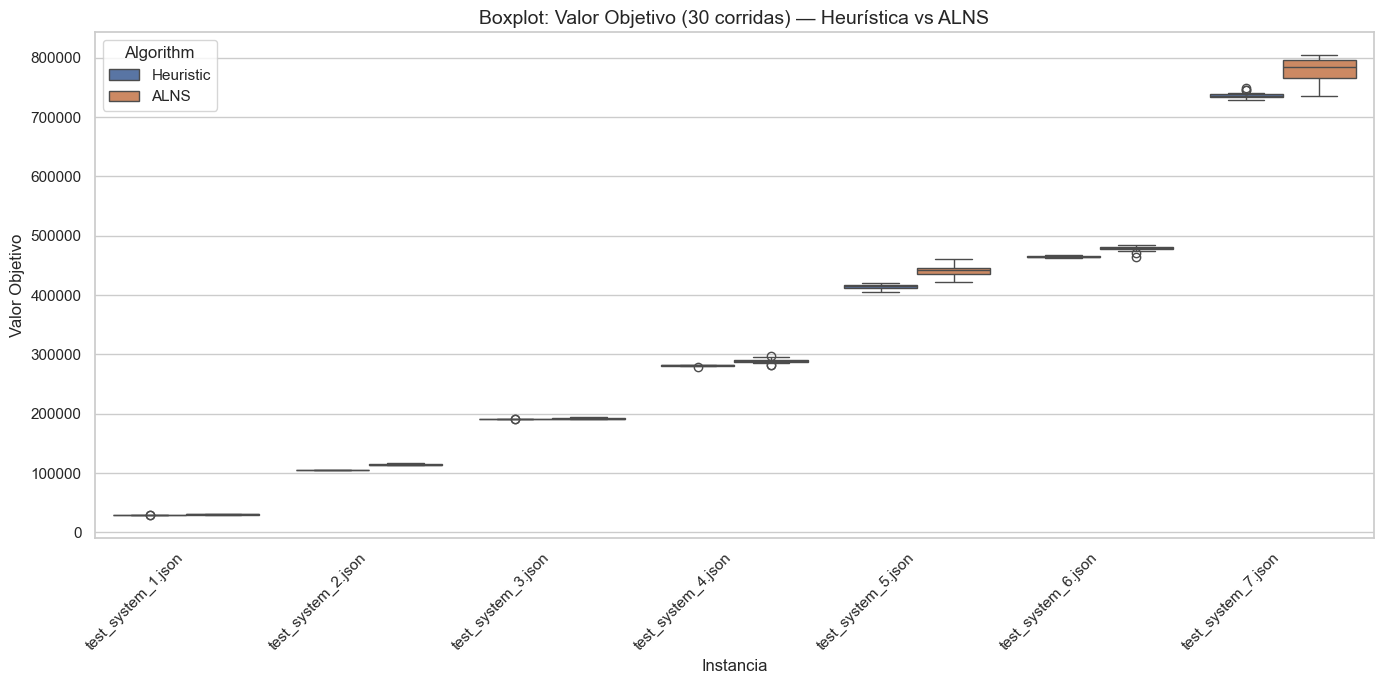

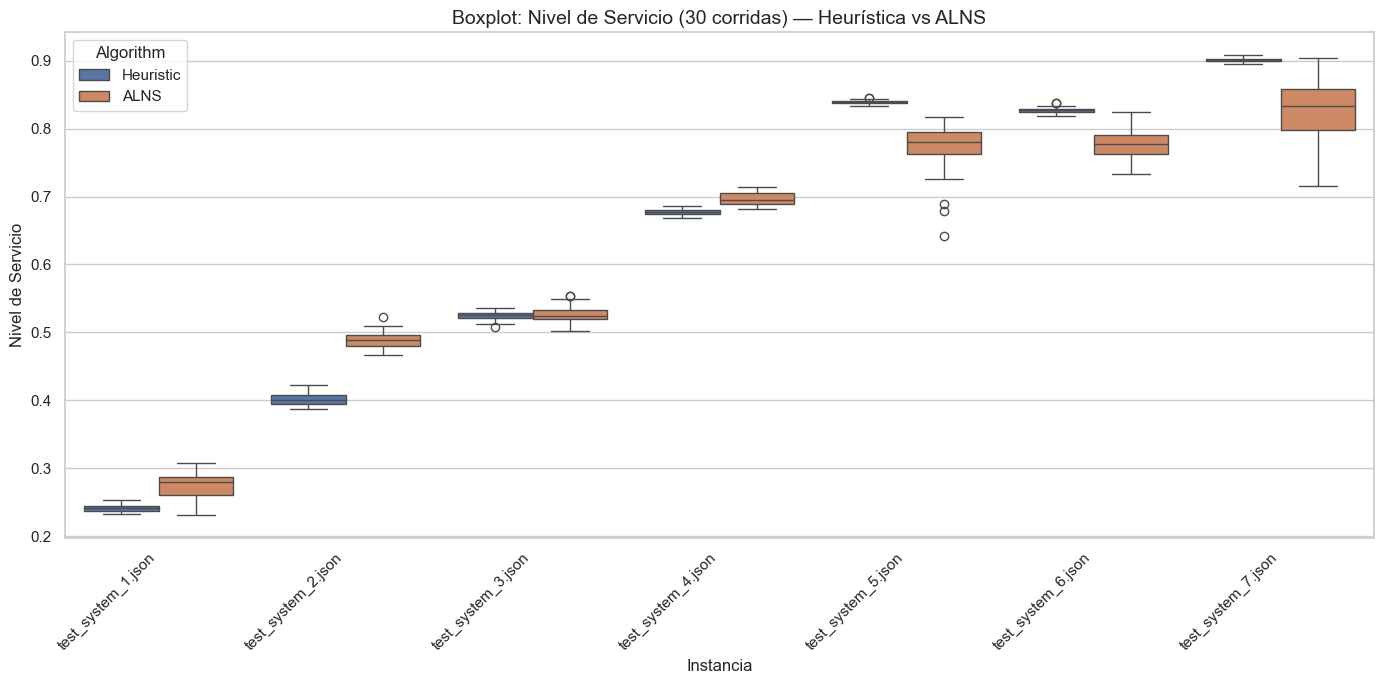

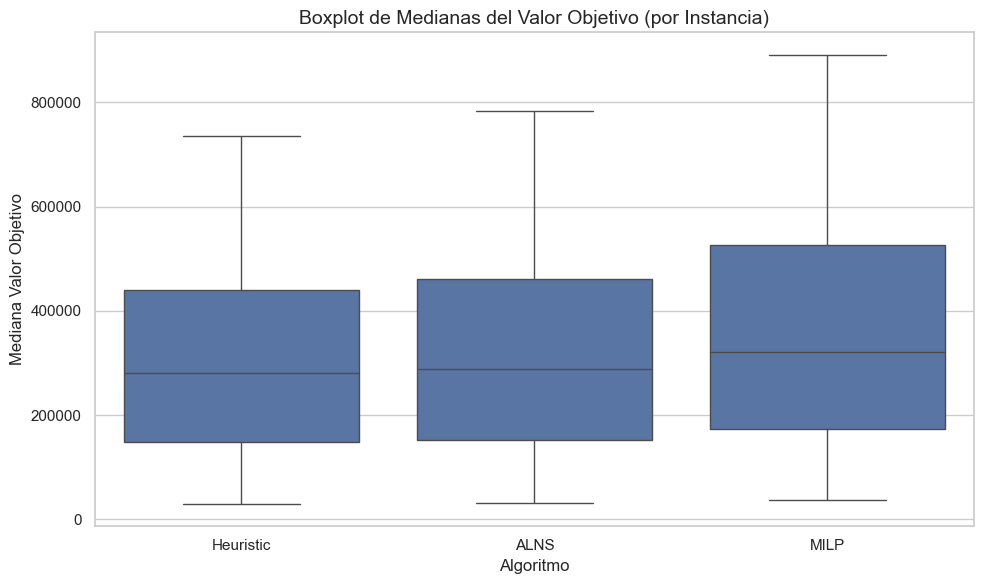

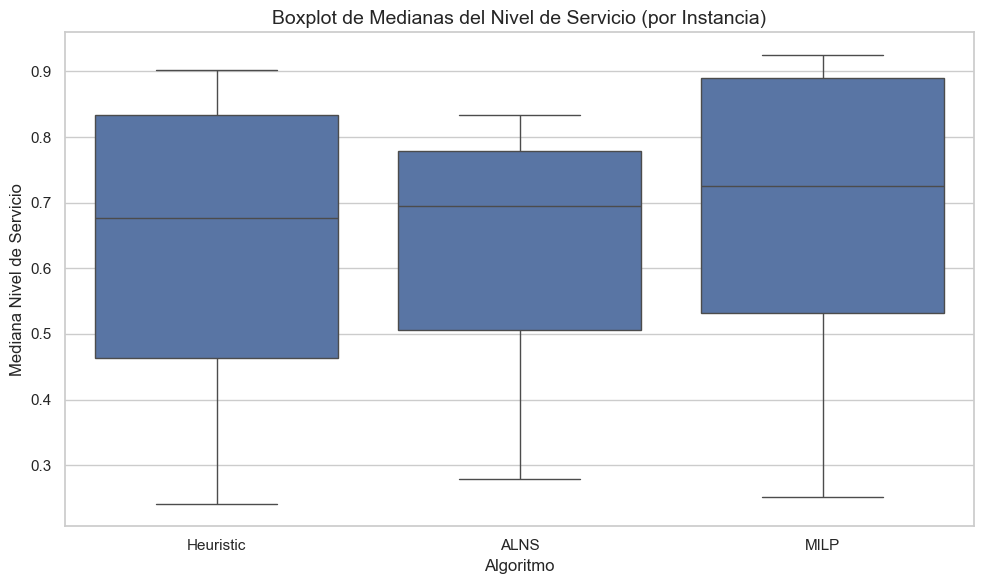


--- Comprobación de Supuestos: Heurística vs ALNS (por instancia) ---

Instancia: test_system_1.json
  Objetivo:
    Shapiro Heurística  p = 0.0394 → No normal
    Shapiro ALNS        p = 0.1366 → Normal
    Levene varianzas    p = 0.0000 → Varianzas distintas
  Nivel de Servicio:
    Shapiro Heurística  p = 0.5898 → Normal
    Shapiro ALNS        p = 0.0267 → No normal
    Levene varianzas    p = 0.0001 → Varianzas distintas

Instancia: test_system_2.json
  Objetivo:
    Shapiro Heurística  p = 0.5004 → Normal
    Shapiro ALNS        p = 0.6771 → Normal
    Levene varianzas    p = 0.0000 → Varianzas distintas
  Nivel de Servicio:
    Shapiro Heurística  p = 0.2454 → Normal
    Shapiro ALNS        p = 0.7701 → Normal
    Levene varianzas    p = 0.0331 → Varianzas distintas

Instancia: test_system_3.json
  Objetivo:
    Shapiro Heurística  p = 0.0465 → No normal
    Shapiro ALNS        p = 0.0000 → No normal
    Levene varianzas    p = 0.0003 → Varianzas distintas
  Nivel de Servicio:


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ────────────────────────────────────────────────────────────────────────────────
# Configuración de rutas y constantes
# ────────────────────────────────────────────────────────────────────────────────
BASE_DIR = "."  # Carpeta donde están los archivos
HEURISTIC_RESULTS_FILE = os.path.join(BASE_DIR, "heuristic_results.xlsx")
ALNS_RESULTS_FILE      = os.path.join(BASE_DIR, "alns_results.xlsx")
MILP_RESULTS_FILE      = os.path.join(BASE_DIR, "milp_results.xlsx")

METRIC_OBJECTIVE      = "objective_value"
METRIC_SERVICE_LEVEL  = "avg_service_level"
ALPHA                 = 0.05  # Nivel de significancia para las pruebas estadísticas

# ────────────────────────────────────────────────────────────────────────────────
# 1. Lectura de datos
# ────────────────────────────────────────────────────────────────────────────────
try:
    df_heur_raw = pd.read_excel(HEURISTIC_RESULTS_FILE, sheet_name="AllRuns")
    df_alns_raw = pd.read_excel(ALNS_RESULTS_FILE,      sheet_name="AllRuns")
    df_milp_raw = pd.read_excel(MILP_RESULTS_FILE)
    print("Archivos cargados correctamente.\n")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo '{e.filename}'. Verifica la ruta.")
    raise
except Exception as e:
    print(f"Error al leer los archivos Excel: {e}")
    raise

# ────────────────────────────────────────────────────────────────────────────────
# 2. Preprocesamiento y consolidación inicial
# ────────────────────────────────────────────────────────────────────────────────
# Heurística
df_heur = df_heur_raw[['instance', 'run_id', METRIC_OBJECTIVE, METRIC_SERVICE_LEVEL]].copy()
df_heur['Algorithm'] = 'Heuristic'

# ALNS
df_alns = df_alns_raw[['instance', 'run_id', METRIC_OBJECTIVE, METRIC_SERVICE_LEVEL]].copy()
df_alns['Algorithm'] = 'ALNS'

# MILP (solo una ejecución por instancia)
df_milp = df_milp_raw[['instance', METRIC_OBJECTIVE, METRIC_SERVICE_LEVEL]].copy()
df_milp['run_id'] = 1
df_milp['Algorithm'] = 'MILP'

# Unificar nombres de columnas
for df in (df_heur, df_alns, df_milp):
    df.rename(columns={'instance': 'instancia',
                       METRIC_OBJECTIVE: 'objetivo',
                       METRIC_SERVICE_LEVEL: 'servicio'},
              inplace=True)

# Combinar todos los datos
df_all_runs = pd.concat([df_heur, df_alns, df_milp], ignore_index=True)
df_all_runs['instancia'] = df_all_runs['instancia'].astype(str)

print("--- Primeras filas del DataFrame combinado (df_all_runs) ---")
print(df_all_runs.head(), "\n")

# ────────────────────────────────────────────────────────────────────────────────
# 3. Agregación de resultados por instancia (medianas, medias, desvíos)
# ────────────────────────────────────────────────────────────────────────────────
# Heurística agregada
df_heur_agg = (
    df_heur
    .groupby('instancia')
    .agg(
        median_obj=('objetivo', 'median'),
        mean_obj=('objetivo', 'mean'),
        std_obj=('objetivo', 'std'),
        median_serv=('servicio', 'median'),
        mean_serv=('servicio', 'mean'),
        std_serv=('servicio', 'std')
    )
    .reset_index()
)
df_heur_agg['Algorithm'] = 'Heuristic'

# ALNS agregada
df_alns_agg = (
    df_alns
    .groupby('instancia')
    .agg(
        median_obj=('objetivo', 'median'),
        mean_obj=('objetivo', 'mean'),
        std_obj=('objetivo', 'std'),
        median_serv=('servicio', 'median'),
        mean_serv=('servicio', 'mean'),
        std_serv=('servicio', 'std')
    )
    .reset_index()
)
df_alns_agg['Algorithm'] = 'ALNS'

# MILP agregada (std = 0 porque solo hay una corrida)
df_milp_agg = df_milp.rename(columns={
    'objetivo': 'median_obj',
    'servicio': 'median_serv'
}).copy()
df_milp_agg['mean_obj'] = df_milp_agg['median_obj']
df_milp_agg['std_obj']  = 0.0
df_milp_agg['mean_serv']= df_milp_agg['median_serv']
df_milp_agg['std_serv'] = 0.0
df_milp_agg = df_milp_agg[['instancia', 'median_obj', 'mean_obj', 'std_obj', 'median_serv', 'mean_serv', 'std_serv']]
df_milp_agg['Algorithm'] = 'MILP'

# Unificar medianas para comparaciones globales
df_aggregated_median = pd.concat([
    df_heur_agg[['instancia', 'Algorithm', 'median_obj', 'median_serv']],
    df_alns_agg[['instancia', 'Algorithm', 'median_obj', 'median_serv']],
    df_milp_agg[['instancia', 'Algorithm', 'median_obj', 'median_serv']]
], ignore_index=True)

print("--- Datos agregados por instancia (medianas) ---")
print(df_aggregated_median.head(), "\n")

# ────────────────────────────────────────────────────────────────────────────────
# 4. Estadísticas descriptivas generales
# ────────────────────────────────────────────────────────────────────────────────
print("--- Estadísticas descriptivas (todas las corridas) por algoritmo ---")
print(
    df_all_runs
    .groupby('Algorithm')[['objetivo', 'servicio']]
    .describe()
    .transpose(),
    "\n"
)

print("--- Estadísticas descriptivas (medianas) por algoritmo ---")
print(
    df_aggregated_median
    .groupby('Algorithm')[['median_obj', 'median_serv']]
    .describe()
    .transpose()
)

# ────────────────────────────────────────────────────────────────────────────────
# 5. Visualizaciones descriptivas
# ────────────────────────────────────────────────────────────────────────────────
sns.set(style="whitegrid")

# Boxplots de todas las corridas (Heurística vs ALNS) por instancia (Objetivo)
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_all_runs[df_all_runs['Algorithm'].isin(['Heuristic', 'ALNS'])],
    x='instancia', y='objetivo', hue='Algorithm'
)
plt.title("Boxplot: Valor Objetivo (30 corridas) — Heurística vs ALNS", fontsize=14)
plt.xlabel("Instancia", fontsize=12)
plt.ylabel("Valor Objetivo", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Boxplots de todas las corridas (Heurística vs ALNS) por instancia (Servicio)
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_all_runs[df_all_runs['Algorithm'].isin(['Heuristic', 'ALNS'])],
    x='instancia', y='servicio', hue='Algorithm'
)
plt.title("Boxplot: Nivel de Servicio (30 corridas) — Heurística vs ALNS", fontsize=14)
plt.xlabel("Instancia", fontsize=12)
plt.ylabel("Nivel de Servicio", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Boxplot de las medianas por instancia para los tres algoritmos (Objetivo)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_aggregated_median, x='Algorithm', y='median_obj')
plt.title("Boxplot de Medianas del Valor Objetivo (por Instancia)", fontsize=14)
plt.xlabel("Algoritmo", fontsize=12)
plt.ylabel("Mediana Valor Objetivo", fontsize=12)
plt.tight_layout()
plt.show()

# Boxplot de las medianas por instancia para los tres algoritmos (Servicio)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_aggregated_median, x='Algorithm', y='median_serv')
plt.title("Boxplot de Medianas del Nivel de Servicio (por Instancia)", fontsize=14)
plt.xlabel("Algoritmo", fontsize=12)
plt.ylabel("Mediana Nivel de Servicio", fontsize=12)
plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# 6. Comprobación de supuestos: Heurística vs ALNS (por instancia)
# ────────────────────────────────────────────────────────────────────────────────
instances = df_heur['instancia'].unique()
assumption_results = []

print("\n--- Comprobación de Supuestos: Heurística vs ALNS (por instancia) ---")
for inst in instances:
    # Datos por instancia
    data_h_obj = df_heur[df_heur['instancia'] == inst]['objetivo']
    data_a_obj = df_alns[df_alns['instancia'] == inst]['objetivo']
    data_h_sl  = df_heur[df_heur['instancia'] == inst]['servicio']
    data_a_sl  = df_alns[df_alns['instancia'] == inst]['servicio']

    # Shapiro-Wilk (Normalidad)
    sw_h_obj_stat, sw_h_obj_p = stats.shapiro(data_h_obj)
    sw_a_obj_stat, sw_a_obj_p = stats.shapiro(data_a_obj)
    sw_h_sl_stat, sw_h_sl_p   = stats.shapiro(data_h_sl)
    sw_a_sl_stat, sw_a_sl_p   = stats.shapiro(data_a_sl)

    # Levene (Homocedasticidad)
    lv_obj_stat, lv_obj_p     = stats.levene(data_h_obj, data_a_obj)
    lv_sl_stat, lv_sl_p       = stats.levene(data_h_sl, data_a_sl)

    assumption_results.append({
        'instancia': inst,
        'SW_Heur_Obj_p': sw_h_obj_p,
        'SW_ALNS_Obj_p': sw_a_obj_p,
        'Levene_Obj_p':    lv_obj_p,
        'SW_Heur_SL_p':   sw_h_sl_p,
        'SW_ALNS_SL_p':   sw_a_sl_p,
        'Levene_SL_p':     lv_sl_p
    })

    print(f"\nInstancia: {inst}")
    print(f"  Objetivo:")
    print(f"    Shapiro Heurística  p = {sw_h_obj_p:.4f} → {'Normal' if sw_h_obj_p > ALPHA else 'No normal'}")
    print(f"    Shapiro ALNS        p = {sw_a_obj_p:.4f} → {'Normal' if sw_a_obj_p > ALPHA else 'No normal'}")
    print(f"    Levene varianzas    p = {lv_obj_p:.4f} → {'Varianzas iguales' if lv_obj_p > ALPHA else 'Varianzas distintas'}")
    print(f"  Nivel de Servicio:")
    print(f"    Shapiro Heurística  p = {sw_h_sl_p:.4f} → {'Normal' if sw_h_sl_p > ALPHA else 'No normal'}")
    print(f"    Shapiro ALNS        p = {sw_a_sl_p:.4f} → {'Normal' if sw_a_sl_p > ALPHA else 'No normal'}")
    print(f"    Levene varianzas    p = {lv_sl_p:.4f} → {'Varianzas iguales' if lv_sl_p > ALPHA else 'Varianzas distintas'}")

df_assumptions = pd.DataFrame(assumption_results)

print("\n--- Resumen Tabla de Supuestos (Heurística vs ALNS por Instancia) ---")
print(df_assumptions)


In [7]:
import pandas as pd
from scipy import stats

# Suponemos que df_heur y df_alns ya están definidos como en el paso anterior.

resultados_mwu = []

for inst in df_heur['instancia'].unique():
    # Extraer las 30 corridas de cada algoritmo
    o_h = df_heur.loc[df_heur['instancia'] == inst, 'objetivo']
    o_a = df_alns.loc[df_alns['instancia'] == inst, 'objetivo']
    s_h = df_heur.loc[df_heur['instancia'] == inst, 'servicio']
    s_a = df_alns.loc[df_alns['instancia'] == inst, 'servicio']

    # Mann–Whitney U sobre "objetivo"
    stat_obj, p_obj = stats.mannwhitneyu(o_h, o_a, alternative="two-sided")
    signif_obj = "Sí" if p_obj < ALPHA else "No"

    # Mann–Whitney U sobre "servicio"
    stat_sl, p_sl = stats.mannwhitneyu(s_h, s_a, alternative="two-sided")
    signif_sl = "Sí" if p_sl < ALPHA else "No"

    resultados_mwu.append({
        'instancia': inst,
        'métrica': 'objetivo',
        'U_statistic': stat_obj,
        'p_valor': p_obj,
        'significativo (α=0.05)': signif_obj
    })
    resultados_mwu.append({
        'instancia': inst,
        'métrica': 'servicio',
        'U_statistic': stat_sl,
        'p_valor': p_sl,
        'significativo (α=0.05)': signif_sl
    })

df_mwu = pd.DataFrame(resultados_mwu)
print("\n--- Resultados Mann–Whitney U (Heurística vs ALNS) ---")
print(df_mwu)



--- Resultados Mann–Whitney U (Heurística vs ALNS) ---
             instancia   métrica  U_statistic       p_valor  \
0   test_system_1.json  objetivo         78.0  3.964765e-08   
1   test_system_1.json  servicio        106.0  3.805263e-07   
2   test_system_2.json  objetivo          0.0  3.019859e-11   
3   test_system_2.json  servicio          0.0  3.019859e-11   
4   test_system_3.json  objetivo        352.0  1.494487e-01   
5   test_system_3.json  servicio        441.0  8.999950e-01   
6   test_system_4.json  objetivo          3.0  4.077165e-11   
7   test_system_4.json  servicio          9.0  7.389083e-11   
8   test_system_5.json  objetivo          0.0  3.019859e-11   
9   test_system_5.json  servicio        900.0  3.019859e-11   
10  test_system_6.json  objetivo         28.0  4.615910e-10   
11  test_system_6.json  servicio        893.0  6.065757e-11   
12  test_system_7.json  objetivo         26.0  3.820160e-10   
13  test_system_7.json  servicio        856.0  2.033797e-09   

Friedman Valor Objetivo: χ²=14.0000, p=0.0009
Friedman Nivel de Servicio: χ²=5.4286, p=0.0663

Post-hoc Nemenyi (Valor Objetivo):
           Heuristic      ALNS      MILP
Heuristic   1.000000  0.147193  0.000536
ALNS        0.147193  1.000000  0.147193
MILP        0.000536  0.147193  1.000000


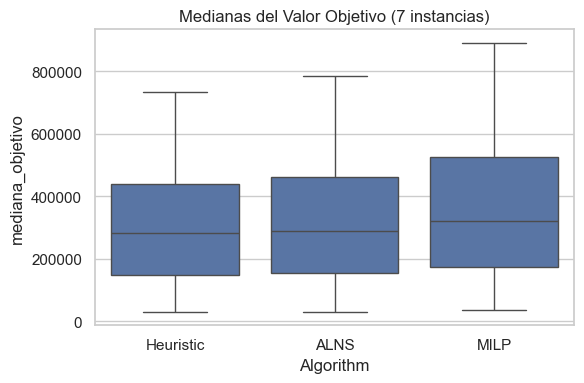

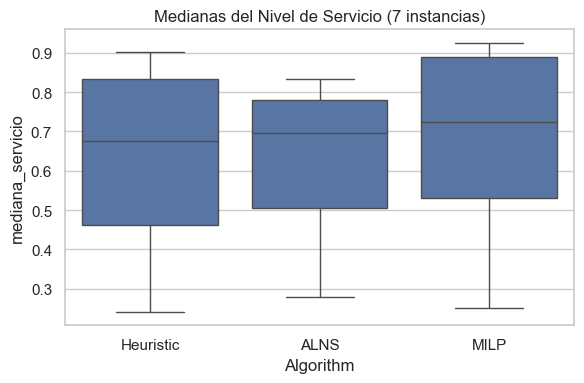

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare
from scipy import stats

# Si se quiere post‐hoc de Nemenyi:
# pip install scikit-posthocs
import scikit_posthocs as sp

BASE_DIR = "."
HEURISTIC_RESULTS_FILE = os.path.join(BASE_DIR, "heuristic_results.xlsx")
ALNS_RESULTS_FILE      = os.path.join(BASE_DIR, "alns_results.xlsx")
MILP_RESULTS_FILE      = os.path.join(BASE_DIR, "milp_results.xlsx")

# 1. Cargar “AllRuns” de Heurística y ALNS, y MILP
df_heur_raw = pd.read_excel(HEURISTIC_RESULTS_FILE, sheet_name="AllRuns")
df_alns_raw = pd.read_excel(ALNS_RESULTS_FILE,      sheet_name="AllRuns")
df_milp_raw = pd.read_excel(MILP_RESULTS_FILE)

# 2. Crear DataFrames “raw” con columnas necesarias:
METRIC_OBJECTIVE = "objective_value"
METRIC_SERVICE   = "avg_service_level"

df_heur = df_heur_raw[['instance','run_id', METRIC_OBJECTIVE, METRIC_SERVICE]].copy()
df_heur.columns = ['instance','run_id','objetivo','servicio']
df_heur['Algorithm'] = 'Heuristic'

df_alns = df_alns_raw[['instance','run_id', METRIC_OBJECTIVE, METRIC_SERVICE]].copy()
df_alns.columns = ['instance','run_id','objetivo','servicio']
df_alns['Algorithm'] = 'ALNS'

df_milp = df_milp_raw[[       METRIC_OBJECTIVE, METRIC_SERVICE]].copy()
df_milp.columns = ['objetivo','servicio']
df_milp['instance'] = df_milp_raw['instance']
df_milp['run_id'] = 1
df_milp['Algorithm'] = 'MILP'

# 3. Agrupar Heurística y ALNS para obtener medianas por instancia:
df_heur_agg = df_heur.groupby('instance').agg(
    mediana_obj=('objetivo','median'),
    mediana_sl=('servicio','median')
).reset_index()
df_alns_agg = df_alns.groupby('instance').agg(
    mediana_obj=('objetivo','median'),
    mediana_sl=('servicio','median')
).reset_index()
df_milp_agg = df_milp.groupby('instance').agg(
    mediana_obj=('objetivo','median'),
    mediana_sl=('servicio','median')
).reset_index()

# 4. Preparar “wide” para Friedman:
h = df_heur_agg.rename(columns={'mediana_obj':'Heuristic_obj','mediana_sl':'Heuristic_sl'})
a = df_alns_agg.rename(columns={'mediana_obj':'ALNS_obj','mediana_sl':'ALNS_sl'})
m = df_milp_agg.rename(columns={'mediana_obj':'MILP_obj','mediana_sl':'MILP_sl'})
df_wide = h.merge(a, on='instance').merge(m, on='instance')

# 5. Friedman sobre Valor Objetivo
stat_obj, p_obj = friedmanchisquare(
    df_wide['Heuristic_obj'],
    df_wide['ALNS_obj'],
    df_wide['MILP_obj']
)
print(f"Friedman Valor Objetivo: χ²={stat_obj:.4f}, p={p_obj:.4f}")

# 5b. Friedman sobre Nivel de Servicio
stat_sl, p_sl = friedmanchisquare(
    df_wide['Heuristic_sl'],
    df_wide['ALNS_sl'],
    df_wide['MILP_sl']
)
print(f"Friedman Nivel de Servicio: χ²={stat_sl:.4f}, p={p_sl:.4f}")

# 6. Si p_obj < 0.05 → Nemenyi (Valor Objetivo)
if p_obj < 0.05:
    df_objetos = df_wide[['Heuristic_obj','ALNS_obj','MILP_obj']]
    p_matrix_obj = sp.posthoc_nemenyi_friedman(df_objetos.values)
    p_matrix_obj.index = ['Heuristic','ALNS','MILP']
    p_matrix_obj.columns = ['Heuristic','ALNS','MILP']
    print("\nPost-hoc Nemenyi (Valor Objetivo):")
    print(p_matrix_obj)

# 7. Si p_sl < 0.05 → Nemenyi (Nivel de Servicio)
if p_sl < 0.05:
    df_serv = df_wide[['Heuristic_sl','ALNS_sl','MILP_sl']]
    p_matrix_sl = sp.posthoc_nemenyi_friedman(df_serv.values)
    p_matrix_sl.index = ['Heuristic','ALNS','MILP']
    p_matrix_sl.columns = ['Heuristic','ALNS','MILP']
    print("\nPost-hoc Nemenyi (Nivel de Servicio):")
    print(p_matrix_sl)

# 8. (Opcional) Visualizar boxplots de medianas
# Valor Objetivo
df_obj_long = df_wide.melt(
    id_vars=['instance'],
    value_vars=['Heuristic_obj','ALNS_obj','MILP_obj'],
    var_name='Algorithm',
    value_name='mediana_objetivo'
)
df_obj_long['Algorithm'] = df_obj_long['Algorithm'].str.replace('_obj','')
plt.figure(figsize=(6,4))
sns.boxplot(data=df_obj_long, x='Algorithm', y='mediana_objetivo')
plt.title("Medianas del Valor Objetivo (7 instancias)")
plt.tight_layout()
plt.show()

# Nivel de Servicio
df_sl_long = df_wide.melt(
    id_vars=['instance'],
    value_vars=['Heuristic_sl','ALNS_sl','MILP_sl'],
    var_name='Algorithm',
    value_name='mediana_servicio'
)
df_sl_long['Algorithm'] = df_sl_long['Algorithm'].str.replace('_sl','')
plt.figure(figsize=(6,4))
sns.boxplot(data=df_sl_long, x='Algorithm', y='mediana_servicio')
plt.title("Medianas del Nivel de Servicio (7 instancias)")
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuración de Rutas y Nombres de Archivo ---
BASE_DIR = "."
HEURISTIC_RESULTS_FILE = os.path.join(BASE_DIR, "heuristic_results.xlsx")
ALNS_RESULTS_FILE      = os.path.join(BASE_DIR, "alns_results.xlsx")
MILP_RESULTS_FILE      = os.path.join(BASE_DIR, "milp_results.xlsx")

# Nombres de las métricas clave
COL_INSTANCE = "instance"
COL_OBJECTIVE = "objective_value"
COL_SERVICE_LEVEL = "avg_service_level"
COL_ENERGY = "avg_energy_delivered_kWh"
COL_CHARGER_UTIL = "avg_charger_utilization_percent"
COL_TX_UTIL = "transformer_utilization_kW"

# Columnas para el DataFrame de gaps
GAP_COLS_PRIMARY = ['instance', 'algorithm', 'gap_objective_percent', 'gap_service_level_percent']
GAP_COLS_SECONDARY = ['instance', 'algorithm', 'gap_energy_percent', 'gap_charger_util_percent', 'gap_tx_util_percent']

# --- 1. Carga de Datos ---
try:
    df_heur_raw = pd.read_excel(HEURISTIC_RESULTS_FILE, sheet_name="AllRuns")
    df_alns_raw = pd.read_excel(ALNS_RESULTS_FILE, sheet_name="AllRuns")
    df_milp = pd.read_excel(MILP_RESULTS_FILE)
    print("Archivos de resultados cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo {e.filename}. Asegúrate de que los archivos Excel estén en la misma carpeta.")
    raise
except Exception as e:
    print(f"Error al cargar los archivos Excel: {e}")
    raise

# --- 2. Pre-procesamiento y Agregación ---
# Seleccionar solo las columnas necesarias y renombrar MILP para facilitar el merge
df_milp_ref = df_milp[[COL_INSTANCE, COL_OBJECTIVE, COL_SERVICE_LEVEL, COL_ENERGY, COL_CHARGER_UTIL, COL_TX_UTIL]].copy()
df_milp_ref.rename(columns={
    COL_OBJECTIVE: 'milp_objective',
    COL_SERVICE_LEVEL: 'milp_service_level',
    COL_ENERGY: 'milp_energy',
    COL_CHARGER_UTIL: 'milp_charger_util',
    COL_TX_UTIL: 'milp_tx_util'
}, inplace=True)

# Calcular la mediana de las 30 corridas para Heurística y ALNS por instancia
df_heur_median = df_heur_raw.groupby(COL_INSTANCE)[[COL_OBJECTIVE, COL_SERVICE_LEVEL, COL_ENERGY, COL_CHARGER_UTIL, COL_TX_UTIL]].median().reset_index()
df_heur_median['algorithm'] = 'Heuristic'

df_alns_median = df_alns_raw.groupby(COL_INSTANCE)[[COL_OBJECTIVE, COL_SERVICE_LEVEL, COL_ENERGY, COL_CHARGER_UTIL, COL_TX_UTIL]].median().reset_index()
df_alns_median['algorithm'] = 'ALNS'

# Combinar Heurística y ALNS
df_approx = pd.concat([df_heur_median, df_alns_median], ignore_index=True)

# Unir con los resultados del MILP
df_comparison = pd.merge(df_approx, df_milp_ref, on=COL_INSTANCE, how='left')

if df_comparison['milp_objective'].isnull().any():
    print("Advertencia: Algunas instancias no tienen correspondencia en los resultados del MILP o hay NaNs.")
    # Podrías decidir cómo manejar esto: rellenar, eliminar filas, o investigar la causa.
    # Por ahora, continuaremos, pero los gaps para esas filas serán NaN.

# --- 3. Cálculo de Gaps ---
# Gap para la función objetivo: (MILP_obj - Approx_obj) / |MILP_obj| * 100
# Un gap positivo significa que MILP es mejor. Un gap negativo significa que el aprox es mejor (¡raro para obj!).
df_comparison['gap_objective_percent'] = \
    (df_comparison['milp_objective'] - df_comparison[COL_OBJECTIVE]) / \
    df_comparison['milp_objective'].abs().replace(0, np.nan) * 100 # Evitar división por cero

# Gap para el nivel de servicio: (MILP_sl - Approx_sl) / MILP_sl * 100
# Asumimos que MILP_sl es el "ideal" o máximo alcanzable.
# Un gap positivo significa que MILP es mejor.
df_comparison['gap_service_level_percent'] = \
    (df_comparison['milp_service_level'] - df_comparison[COL_SERVICE_LEVEL]) / \
    df_comparison['milp_service_level'].replace(0, np.nan) * 100 # Evitar división por cero

# Gaps para otras métricas (considerar la dirección deseada)
# Para energía entregada, asumimos que más es mejor, así que MILP sería el benchmark superior.
df_comparison['gap_energy_percent'] = \
    (df_comparison['milp_energy'] - df_comparison[COL_ENERGY]) / \
    df_comparison['milp_energy'].abs().replace(0, np.nan) * 100

# Para utilización de cargadores y transformador, el "gap" puede ser menos directo.
# Podríamos mostrar la diferencia absoluta o relativa respecto a MILP.
# Aquí calcularemos la diferencia porcentual (Approx_util - MILP_util) / MILP_util * 100
# Un gap positivo significa que el aprox usa más el recurso que MILP.
df_comparison['gap_charger_util_percent'] = \
    (df_comparison[COL_CHARGER_UTIL] - df_comparison['milp_charger_util']) / \
    df_comparison['milp_charger_util'].abs().replace(0, np.nan) * 100

df_comparison['gap_tx_util_percent'] = \
    (df_comparison[COL_TX_UTIL] - df_comparison['milp_tx_util']) / \
    df_comparison['milp_tx_util'].abs().replace(0, np.nan) * 100

# Separar DataFrames de Gaps
df_gaps_primary = df_comparison[GAP_COLS_PRIMARY].copy()
df_gaps_secondary = df_comparison[GAP_COLS_SECONDARY].copy()

print("\n--- Gaps Primarios (Objetivo y Nivel de Servicio) ---")
print(df_gaps_primary)
print("\n--- Gaps Secundarios (Otras Métricas) ---")
print(df_gaps_secondary)


Archivos de resultados cargados exitosamente.

--- Gaps Primarios (Objetivo y Nivel de Servicio) ---
              instance  algorithm  gap_objective_percent  \
0   test_system_1.json  Heuristic              17.253433   
1   test_system_2.json  Heuristic              21.873866   
2   test_system_3.json  Heuristic              10.367095   
3   test_system_4.json  Heuristic              12.606513   
4   test_system_5.json  Heuristic              19.241314   
5   test_system_6.json  Heuristic              13.891173   
6   test_system_7.json  Heuristic              17.543802   
7   test_system_1.json       ALNS              15.988835   
8   test_system_2.json       ALNS              14.856211   
9   test_system_3.json       ALNS              10.302456   
10  test_system_4.json       ALNS              10.118103   
11  test_system_5.json       ALNS              13.776167   
12  test_system_6.json       ALNS              11.282099   
13  test_system_7.json       ALNS              12.083996   